<a href="https://colab.research.google.com/github/hawa1983/DATA-608/blob/main/DATA_608_HW2_Analytical_Approach_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose of the Modeling and Analysis
The purpose of this analysis is to understand the **relationship between key economic variables**—namely, the **Consumer Price Index (CPI)**, the **Unemployment Rate**, and the **Federal Funds Rate**—during the period of the **Financial Crisis (2007–2011)**, by examining how changes in these variables influence each other over time.

Specifically, the analysis aims to:

1. **Investigate Lag Effects**: Economic responses often don’t happen immediately. For example, changes in monetary policy (such as adjustments in the Federal Funds Rate) may take months to impact unemployment or inflation (CPI). This analysis tests how well lagged data—like unemployment values delayed by several months—can be predicted using current CPI and interest rates. By determining the optimal lag (in months), the analysis identifies the time delay after which changes in CPI and Fed Funds Rate most effectively predict unemployment.

2. **Fit a Predictive Model**: Using **linear regression**, the analysis tries to fit a model to predict the **lagged unemployment rate** based on the **CPI**, **Fed Funds Rate**, and possibly their combined (interaction) effects. This helps policymakers understand how these factors drive unemployment over time and identify which relationships are most significant during the given economic period.

3. **Optimize Policy Timing**: By identifying the optimal time lag between changes in monetary policy (Fed Funds Rate) and unemployment responses, policymakers can gauge how long they might have to wait for their policy actions (e.g., rate hikes or cuts) to influence the job market or inflation. This is crucial for decision-making around economic recovery efforts and ensuring timely interventions.

4. **Evaluate Model Fit**: The analysis evaluates the goodness of fit (using **R-squared**) to determine how well the selected variables and models (with and without interaction terms) explain the variation in unemployment over time. This helps gauge the predictive power of the model and identify whether more complex models (with interactions) perform better than simpler ones.

### Overall Goal:
The analysis is designed to provide insights into **how economic indicators like inflation (CPI), unemployment, and interest rates interact over time**, particularly in periods of economic downturn (like the Financial Crisis). It helps policymakers assess the **impact of their monetary policies** on unemployment and inflation, and how they might time interventions for the best effect.

# Load the data from API

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
import yaml
import matplotlib.dates as mdates  # Import mdates for correct date formatting
import requests
import seaborn as sns
from matplotlib.patches import Patch
import yaml
from datetime import datetime

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date
start_date = '1998-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date='1998-01-01'):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# 1. Modeling Unemployment as Target using CPI and Fed Funds Rate are Explanatory Variable

We are modeling to determine the relationship between the lagged unemployment rate, CPI, and the Fed Funds Rate, including any combined (interaction) effects. This helps assess how changes in inflation and monetary policy impact unemployment over time, optimizing the lag to better understand delayed effects.

## Multiple linear regression model for a 12-month lag for unemployment using entire dataset
To use a 12-month lag for unemployment in the multiple linear regression model, we directly set the lag to 12 months.

**Key Steps:**
1. The lag is fixed at 12 months using the create_lagged_unemployment function.
2. The multiple linear regression is performed on the 12-month lagged unemployment data, CPI, and the federal funds rate.

This approach directly applies a 12-month lag.

## Multiple Linear regression using optimization to determine the lag parameter of unemployment
To perform multiple regression with a lagged unemployment variable and use optimization to determine the best lag for the unemployment data, we'll follow these steps:

**Key Parts of the Code:**
* **Lagged Unemployment:** The create_lagged_unemployment function shifts the unemployment data by a given number of months. I used 12 months.
* **Optimization:** We use the scipy.optimize.minimize function to find the lag that maximizes the R-squared value of the regression model.
* **Multiple Regression:** The regression model includes CPI and Fed Funds Rate as predictors, and lagged unemployment as the dependent variable.
* **Visualization:** We plot both the actual and predicted lagged unemployment rates to visualize the performance of the model.

Below is the code:

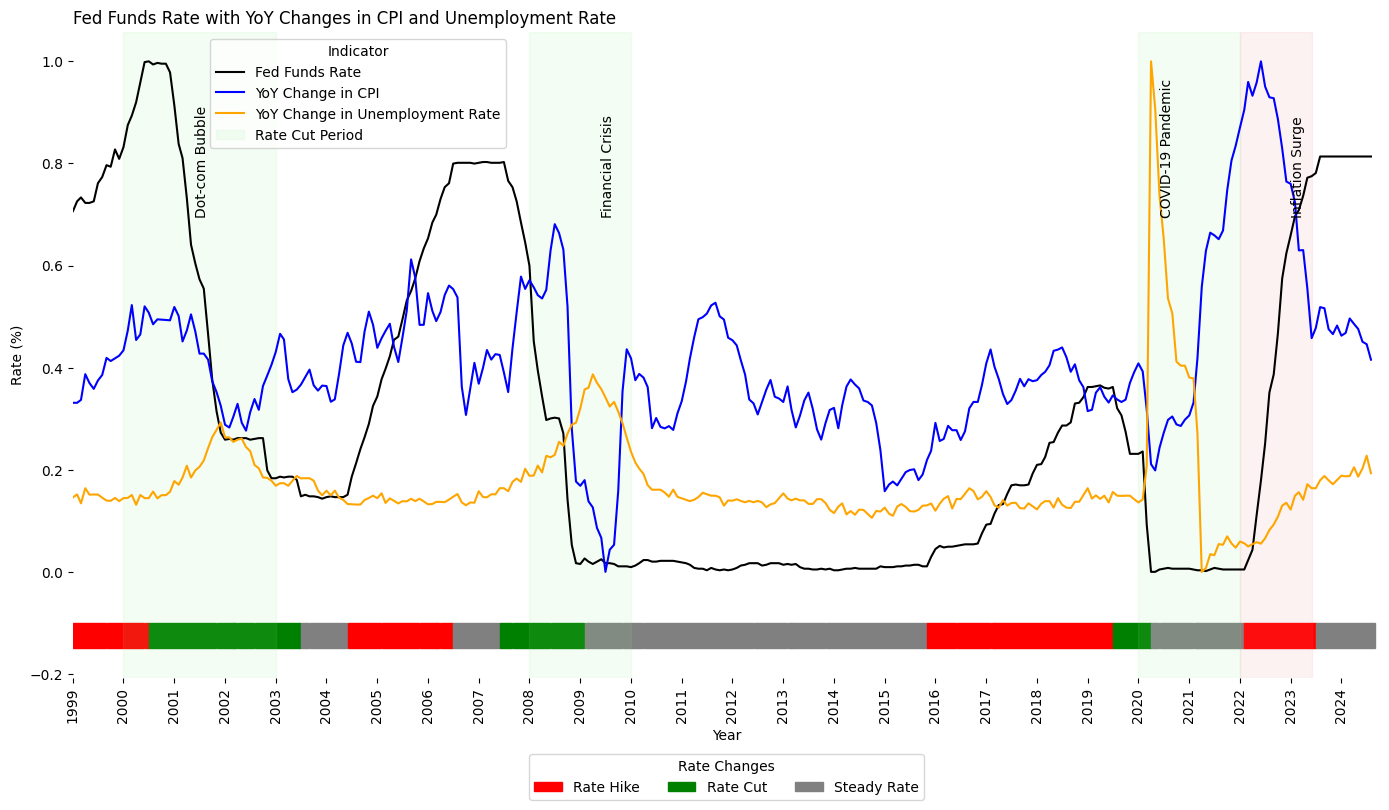

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import yaml
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates  # Import mdates for correct date formatting

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date
start_date = '1998-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Function to fetch data from FRED API
def fetch_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'])
        return df[['date', 'value']]
    else:
        raise Exception(f"Error fetching {series_id} data: {response.status_code}")

# Fetch CPI, Unemployment, and Fed Funds Rate data
cpi_data = fetch_fred_data('CPIAUCSL', api_key, start_date, end_date)
unemployment_data = fetch_fred_data('UNRATE', api_key, start_date, end_date)
fedfunds_data = fetch_fred_data('FEDFUNDS', api_key, start_date, end_date)

# Rename columns for easier handling
cpi_data.rename(columns={'value': 'CPI'}, inplace=True)
unemployment_data.rename(columns={'value': 'Unemployment_Rate'}, inplace=True)
fedfunds_data.rename(columns={'value': 'FEDFUNDS'}, inplace=True)

# Calculate YoY Percentage Change for CPI and Unemployment
cpi_data['YoY_Change_CPI'] = cpi_data['CPI'].pct_change(periods=12) * 100
unemployment_data['YoY_Change_Unemployment'] = unemployment_data['Unemployment_Rate'].pct_change(periods=12) * 100

# Merge the data
merged_df = pd.merge(cpi_data[['date', 'YoY_Change_CPI']], unemployment_data[['date', 'YoY_Change_Unemployment']], on='date')
merged_df = pd.merge(merged_df, fedfunds_data[['date', 'FEDFUNDS']], on='date')

# Normalize using Min-Max scaling
scaler = MinMaxScaler()
merged_df[['YoY_Change_CPI', 'YoY_Change_Unemployment', 'FEDFUNDS']] = scaler.fit_transform(merged_df[['YoY_Change_CPI', 'YoY_Change_Unemployment', 'FEDFUNDS']])

# Define color scheme based on time periods
def rate_color_map(date):
    if date >= pd.to_datetime("1999-01-01") and date <= pd.to_datetime("2000-06-01"):
        return 'red'
    elif date >= pd.to_datetime("2000-06-01") and date <= pd.to_datetime("2003-06-01"):
        return 'green'
    elif date >= pd.to_datetime("2004-06-01") and date <= pd.to_datetime("2006-06-01"):
        return 'red'
    elif date >= pd.to_datetime("2007-06-01") and date <= pd.to_datetime("2009-01-01"):
        return 'green'
    elif date >= pd.to_datetime("2015-11-01") and date <= pd.to_datetime("2019-06-01"):
        return 'red'
    elif date >= pd.to_datetime("2019-07-01") and date <= pd.to_datetime("2020-03-01"):
        return 'green'
    elif date >= pd.to_datetime("2022-02-01") and date <= pd.to_datetime("2023-06-01"):
        return 'red'
    else:
        return 'grey'

# Apply color scheme to data
merged_df['RateCategory'] = merged_df['date'].apply(rate_color_map)

# Create the heatmap data
heatmap_data = merged_df[['date', 'RateCategory']]

# Create a larger bottom margin to accommodate the heatmap below the x-axis
plt.figure(figsize=(14, 8))
plt.subplots_adjust(bottom=0.2)  # Adjust the bottom margin for heatmap

# Plot the rate change heatmap as tiles on the bottom border of the plot (below x-axis)
for i in range(len(heatmap_data)):
    plt.gca().add_patch(
        plt.Rectangle(
            (heatmap_data.iloc[i]['date'], -0.15),  # Move heatmap below x-axis (-0.15)
            pd.Timedelta(days=30),  # Width in days
            0.05,  # Height of the heatmap tile
            color=heatmap_data.iloc[i]['RateCategory']
        )
    )

# Plot FEDFUNDS, YoY Change in CPI, and YoY Change in Unemployment
sns.lineplot(data=merged_df, x='date', y='FEDFUNDS', label='Fed Funds Rate', color='black')
sns.lineplot(data=merged_df, x='date', y='YoY_Change_CPI', label='YoY Change in CPI', color='blue')
sns.lineplot(data=merged_df, x='date', y='YoY_Change_Unemployment', label='YoY Change in Unemployment Rate', color='orange')

# Highlight periods with colored bands
plt.axvspan(pd.to_datetime("2000-01-01"), pd.to_datetime("2002-12-31"), color="lightgreen", alpha=0.1, label='Rate Cut Period')
plt.axvspan(pd.to_datetime("2008-01-01"), pd.to_datetime("2009-12-31"), color="lightgreen", alpha=0.1)
plt.axvspan(pd.to_datetime("2020-01-01"), pd.to_datetime("2021-12-31"), color="lightgreen", alpha=0.1)
plt.axvspan(pd.to_datetime("2022-01-01"), pd.to_datetime("2023-06-01"), color="lightcoral", alpha=0.1)

# Add labels for significant periods
plt.text(pd.to_datetime("2001-06-01"), 0.7, "Dot-com Bubble", rotation=90)
plt.text(pd.to_datetime("2009-06-01"), 0.7, "Financial Crisis", rotation=90)
plt.text(pd.to_datetime("2020-06-01"), 0.7, "COVID-19 Pandemic", rotation=90)
plt.text(pd.to_datetime("2023-01-01"), 0.7, "Inflation Surge", rotation=90)

# Correctly format the x-axis to display years properly
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Set ticks every 4 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the ticks as years

# Set x-axis limits and labels
plt.xlim(pd.to_datetime("1999-01-01"), pd.to_datetime(end_date))
plt.xticks(rotation=90)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.title('Fed Funds Rate with YoY Changes in CPI and Unemployment Rate', loc='left')

# Custom legend for the heatmap
heatmap_legend = [Patch(color='red', label='Rate Hike'),
                  Patch(color='green', label='Rate Cut'),
                  Patch(color='grey', label='Steady Rate')]

# Legend for lines
line_legend = plt.legend(loc='upper left', bbox_to_anchor=(0.1, 1), title="Indicator")
plt.gca().add_artist(line_legend)

# Add heatmap legend
plt.legend(handles=heatmap_legend, loc='lower center', bbox_to_anchor=(0.5, -0.2), title="Rate Changes", ncol=3)

# Remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Show plot
plt.tight_layout()
plt.show()


Global maximum FEDFUNDS occurred on: 2000-12-01 00:00:00
Global maximum of Fed Funds Rate occurred on: 2000-12-01 00:00:00
Global maximum Unemployment Rate occurred on: 2002-12-01 00:00:00
Global maximum of Unemployment Rate occurred on: 2002-12-01 00:00:00
Global maximum lag is: 24 months
The linear model equation is:
Lagged Unemployment = 0.2084 * Federal Funds Rate + 0.0763
R-squared: 0.7005


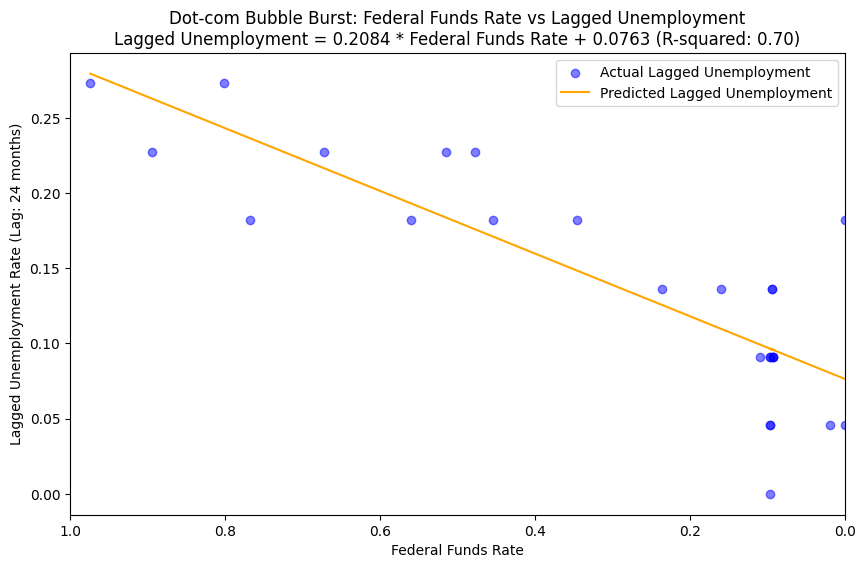

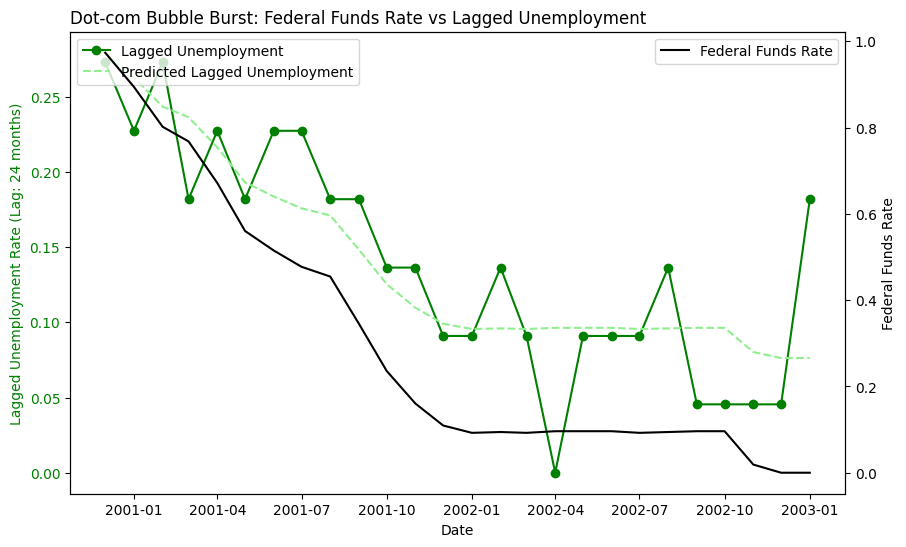

In [62]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
import yaml

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date for the initial data fetch
start_date = '1998-12-01'
end_date = '2003-01-01'

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Smoothing function (adjust window size for moving average)
def smooth_data(data, window_size=9):
    return data.rolling(window=window_size).mean()

# Directly find the global maximum of the unemployment or fed data within the provided date range
def find_global_maximum(data, column_name):
    smoothed_data = smooth_data(data[column_name])
    global_max_idx = smoothed_data.idxmax()  # Find the index of the global maximum
    global_max_date = data.loc[global_max_idx, 'Date']  # Get the date of the global maximum
    print(f"Global maximum {column_name} occurred on: {global_max_date}")
    return global_max_date

# Apply a lag to unemployment data
def create_lagged_unemployment(data, lag):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)  # Apply lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Retrieve unemployment and fed rate data
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)

# Rename columns for clarity
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(unemployment_df, fed_rate_df, on='Date')
merged_df.dropna(inplace=True)

# Normalize the Unemployment Rate and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(merged_df[['Unemployment Rate', 'FEDFUNDS']])

# Step 1: Find the global maximum of the Fed Funds Rate and use that as the starting point
global_max_fed_date = find_global_maximum(merged_df, 'FEDFUNDS')
print(f"Global maximum of Fed Funds Rate occurred on: {global_max_fed_date}")

# Step 2: Now find the global maximum of unemployment *within* the same time window
global_max_unemployment_date = find_global_maximum(merged_df, 'Unemployment Rate')
print(f"Global maximum of Unemployment Rate occurred on: {global_max_unemployment_date}")

# Step 3: Calculate the lag in months between the Fed Funds Rate peak and the Unemployment Rate peak
global_max_lag = (pd.to_datetime(global_max_unemployment_date) - pd.to_datetime(global_max_fed_date)).days // 30
print(f"Global maximum lag is: {global_max_lag} months")

# Step 4: Apply the optimal lag to unemployment data
lagged_data = create_lagged_unemployment(merged_df, global_max_lag)

# Step 5: Perform the linear regression with the lagged unemployment data
X = lagged_data[['FEDFUNDS']]
y = lagged_data['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_[0]
intercept = model.intercept_

# Display the equation with variable names
equation = f"Lagged Unemployment = {coefficients:.4f} * Federal Funds Rate + {intercept:.4f}"
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)
print(f"R-squared: {r_squared:.4f}")

# Plot the scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Lagged Unemployment', color='blue', alpha=0.5)
plt.plot(X, y_pred, label='Predicted Lagged Unemployment', color='orange')
plt.xlabel('Federal Funds Rate')
plt.ylabel(f'Lagged Unemployment Rate (Lag: {global_max_lag} months)')
plt.title(f'Dot-com Bubble Burst: Federal Funds Rate vs Lagged Unemployment\n{equation} (R-squared: {r_squared:.2f})')
plt.legend()

# Set the x-axis limits from 1 to 0
plt.xlim(1, 0)

plt.show()



# Plot the time series of actual vs predicted lagged unemployment with Fed Funds Rate on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the lagged unemployment on the primary axis
ax1.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o', color='green')
ax1.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--', color='lightgreen')
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Lagged Unemployment Rate (Lag: {global_max_lag} months)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create a secondary axis for the Fed Funds Rate
ax2 = ax1.twinx()
ax2.plot(lagged_data['Date'], lagged_data['FEDFUNDS'], label='Federal Funds Rate', color='black')
ax2.set_ylabel('Federal Funds Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and legends
plt.title('Dot-com Bubble Burst: Federal Funds Rate vs Lagged Unemployment', loc='left')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


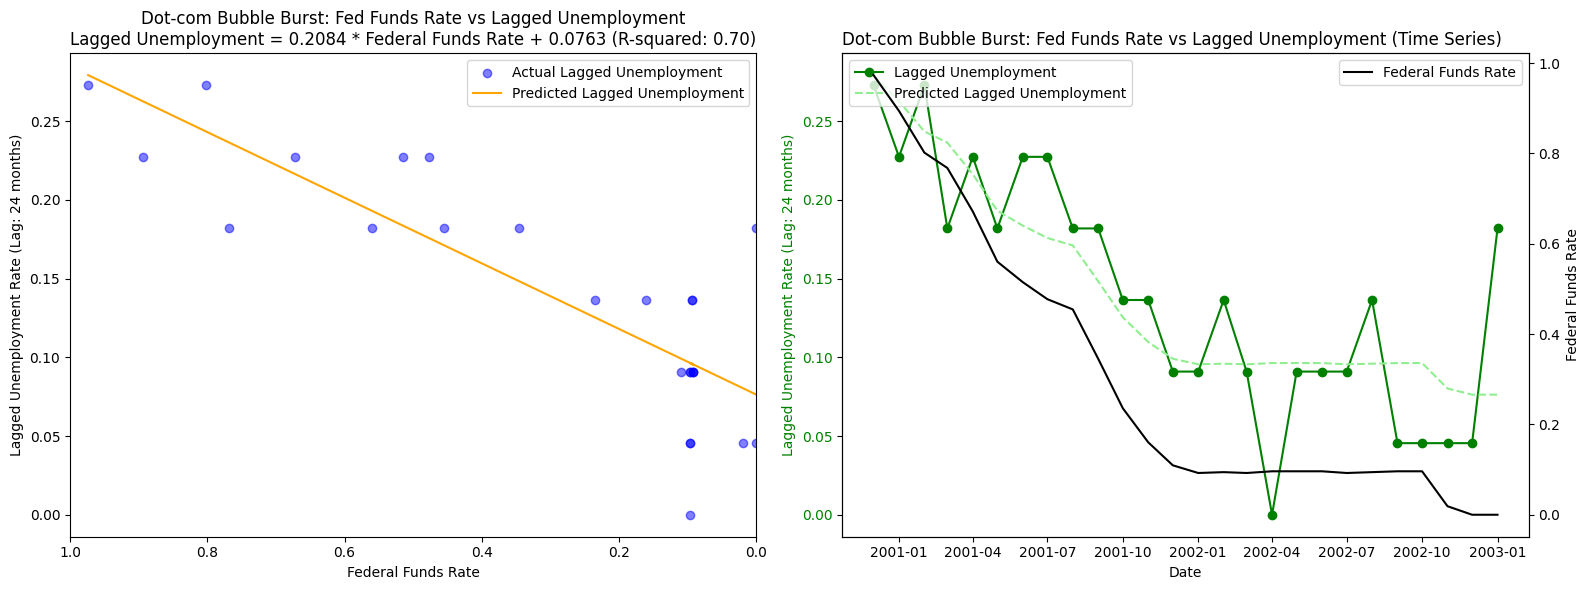

In [ ]:
# Create a figure with two columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter plot with regression line on the first axis (left column)
ax1.scatter(X, y, label='Actual Lagged Unemployment', color='blue', alpha=0.5)
ax1.plot(X, y_pred, label='Predicted Lagged Unemployment', color='orange')
ax1.set_xlabel('Federal Funds Rate')
ax1.set_ylabel(f'Lagged Unemployment Rate (Lag: {global_max_lag} months)')
ax1.set_title(f'Dot-com Bubble Burst: Fed Funds Rate vs Lagged Unemployment\n{equation} (R-squared: {r_squared:.2f})')
ax1.legend()

# Reverse the x-axis to start from 1 to 0
ax1.set_xlim(1, 0)

# Plot 2: Time series of actual vs predicted lagged unemployment with Fed Funds Rate on secondary axis (right column)
ax3 = ax2.twinx()  # Create a secondary y-axis for the second plot

# Plot the lagged unemployment on the primary axis
ax2.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o', color='green')
ax2.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--', color='lightgreen')
ax2.set_xlabel('Date')
ax2.set_ylabel(f'Lagged Unemployment Rate (Lag: {global_max_lag} months)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Plot the Fed Funds Rate on the secondary axis
ax3.plot(lagged_data['Date'], lagged_data['FEDFUNDS'], label='Federal Funds Rate', color='black')
ax3.set_ylabel('Federal Funds Rate', color='black')
ax3.tick_params(axis='y', labelcolor='black')

# Set the title and legends
ax2.set_title('Dot-com Bubble Burst: Fed Funds Rate vs Lagged Unemployment (Time Series)', loc='left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper right')

# Adjust the layout to prevent overlap
plt.tight_layout()

plt.show()


Global maximum FEDFUNDS occurred on: 2000-12-01 00:00:00
Global maximum of Fed Funds Rate occurred on: 2000-12-01 00:00:00
Global minimum CPI occurred after 2000-12-01 00:00:00 on: 2001-09-01 00:00:00
Global minimum of CPI occurred after Fed Funds maximum on: 2001-09-01 00:00:00
Global minimum lag is: 9 months
The linear model equation is:
Lagged CPI = -0.6244 * Federal Funds Rate + 0.7634
R-squared: 0.7941


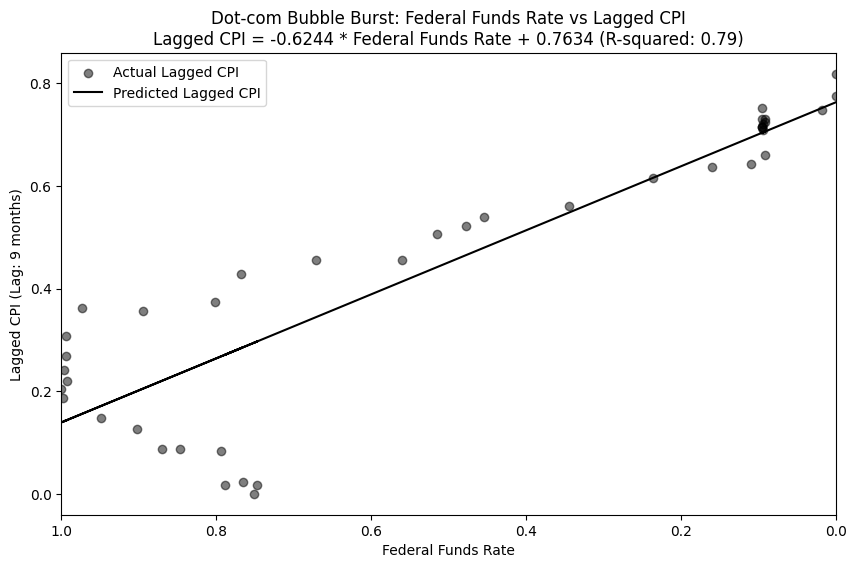

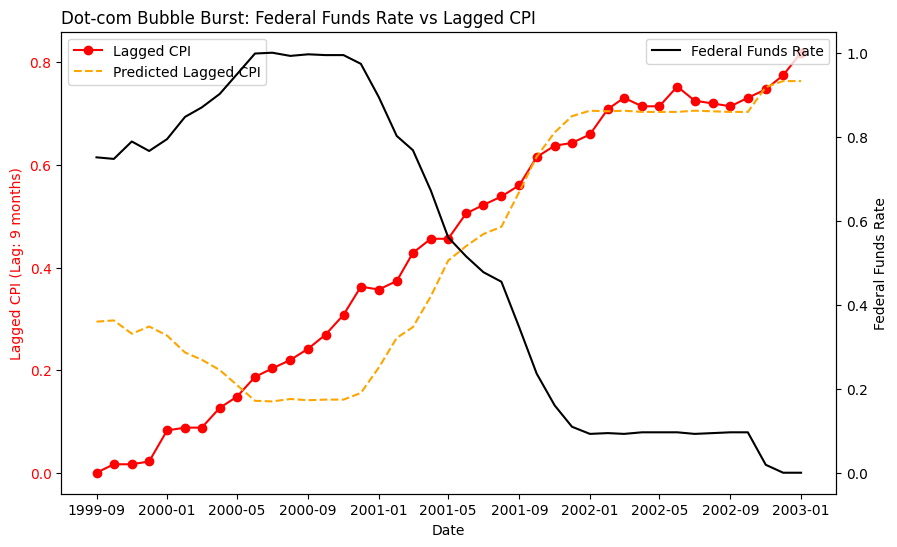

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
import yaml

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date for the initial data fetch
start_date = '1998-12-01'
end_date = '2003-01-01'

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Smoothing function (adjust window size for moving average)
def smooth_data(data, window_size=9):
    return data.rolling(window=window_size).mean()

# Directly find the global maximum of the data
def find_global_maximum(data, column_name):
    smoothed_data = smooth_data(data[column_name])
    global_max_idx = smoothed_data.idxmax()  # Find the index of the global maximum
    global_max_date = data.loc[global_max_idx, 'Date']  # Get the date of the global maximum
    print(f"Global maximum {column_name} occurred on: {global_max_date}")
    return global_max_date

# Directly find the global minimum of CPI data after the global maximum of Fed Funds Rate
def find_global_minimum_after(data, column_name, start_date):
    data_after_start = data[data['Date'] > start_date]  # Filter data after the given date
    smoothed_data = smooth_data(data_after_start[column_name])
    global_min_idx = smoothed_data.idxmin()  # Find the index of the global minimum
    global_min_date = data_after_start.loc[global_min_idx, 'Date']  # Get the date of the global minimum
    print(f"Global minimum {column_name} occurred after {start_date} on: {global_min_date}")
    return global_min_date

# Apply a lag to CPI data (instead of unemployment)
def create_lagged_cpi(data, lag):
    data['Lagged_CPI'] = data['CPI'].shift(lag)  # Apply lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Retrieve CPI and fed rate data
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, fed_rate_df, on='Date')
merged_df.dropna(inplace=True)

# Normalize the CPI and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'FEDFUNDS']] = scaler.fit_transform(merged_df[['CPI', 'FEDFUNDS']])

# Step 1: Find the global maximum of the Fed Funds Rate and use that as the starting point
global_max_fed_date = find_global_maximum(merged_df, 'FEDFUNDS')
print(f"Global maximum of Fed Funds Rate occurred on: {global_max_fed_date}")

# Step 2: Now find the global minimum of CPI *after* the global maximum of the Fed Funds Rate
global_min_cpi_date = find_global_minimum_after(merged_df, 'CPI', global_max_fed_date)
print(f"Global minimum of CPI occurred after Fed Funds maximum on: {global_min_cpi_date}")

# Step 3: Calculate the lag in months between the Fed Funds Rate peak and the CPI minimum
global_min_lag = (pd.to_datetime(global_min_cpi_date) - pd.to_datetime(global_max_fed_date)).days // 30
print(f"Global minimum lag is: {global_min_lag} months")

# Step 4: Apply the optimal lag to CPI data
lagged_data = create_lagged_cpi(merged_df, global_min_lag)

# Step 5: Perform the linear regression with the lagged CPI data
X = lagged_data[['FEDFUNDS']]
y = lagged_data['Lagged_CPI']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_[0]
intercept = model.intercept_

# Display the equation with variable names
equation = f"Lagged CPI = {coefficients:.4f} * Federal Funds Rate + {intercept:.4f}"
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)
print(f"R-squared: {r_squared:.4f}")

# Plot the scatter plot with regression line and reverse the x-axis from 1 to 0
plt.figure(figsize=(10, 6))
plt.scatter(X['FEDFUNDS'], y, label='Actual Lagged CPI', color='black', alpha=0.5)
plt.plot(X['FEDFUNDS'], y_pred, label='Predicted Lagged CPI', color='black')
plt.xlabel('Federal Funds Rate')
plt.ylabel(f'Lagged CPI (Lag: {global_min_lag} months)')
plt.title(f'Dot-com Bubble Burst: Federal Funds Rate vs Lagged CPI\n{equation} (R-squared: {r_squared:.2f})')

# Set the x-axis limits from 1 to 0
plt.xlim(1, 0)

plt.legend()
plt.show()


# Plot the time series of actual vs predicted lagged CPI with Fed Funds Rate on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the lagged CPI on the primary axis
ax1.plot(lagged_data['Date'], y, label='Lagged CPI', marker='o', color='red')
ax1.plot(lagged_data['Date'], y_pred, label='Predicted Lagged CPI', linestyle='--', color='orange')
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Lagged CPI (Lag: {global_min_lag} months)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a secondary axis for the Fed Funds Rate
ax2 = ax1.twinx()
ax2.plot(lagged_data['Date'], lagged_data['FEDFUNDS'], label='Federal Funds Rate', color='black')
ax2.set_ylabel('Federal Funds Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and legends
plt.title('Dot-com Bubble Burst: Federal Funds Rate vs Lagged CPI', loc='left')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


## Financial Crisis

Global maximum FEDFUNDS occurred on: 2007-07-01 00:00:00
Global maximum of Fed Funds Rate occurred on: 2007-07-01 00:00:00
Global maximum Unemployment Rate occurred on: 2009-01-01 00:00:00
Global maximum of Unemployment Rate occurred on: 2009-01-01 00:00:00
Global maximum lag is: 18 months
The linear model equation is:
Lagged Unemployment = 0.0643 * Federal Funds Rate + 0.0201
R-squared: 0.3300


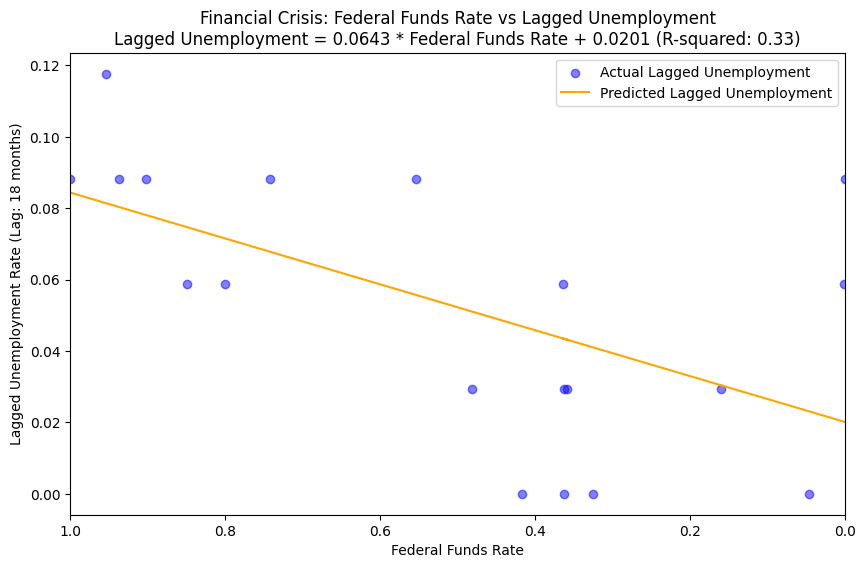

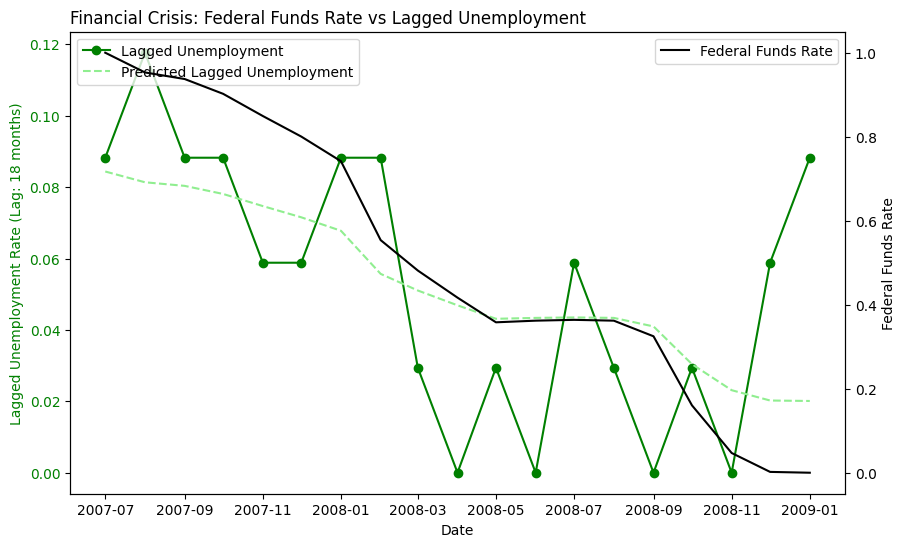

In [84]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
import yaml

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date for the data fetch
start_date = '2006-01-01'  # Preceding the financial crisis period
end_date = '2009-01-01'  # End date near the end of the financial crisis and beyond

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Smoothing function (adjust window size for moving average)
def smooth_data(data, window_size=9):
    return data.rolling(window=window_size).mean()

# Directly find the global maximum of the unemployment or fed data within the provided date range
def find_global_maximum(data, column_name):
    smoothed_data = smooth_data(data[column_name])
    global_max_idx = smoothed_data.idxmax()  # Find the index of the global maximum
    global_max_date = data.loc[global_max_idx, 'Date']  # Get the date of the global maximum
    print(f"Global maximum {column_name} occurred on: {global_max_date}")
    return global_max_date

# Apply a lag to unemployment data
def create_lagged_unemployment(data, lag):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)  # Apply lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Retrieve unemployment and fed rate data
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)

# Rename columns for clarity
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(unemployment_df, fed_rate_df, on='Date')
merged_df.dropna(inplace=True)

# Normalize the Unemployment Rate and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(merged_df[['Unemployment Rate', 'FEDFUNDS']])

# Step 1: Find the global maximum of the Fed Funds Rate and use that as the starting point
global_max_fed_date = find_global_maximum(merged_df, 'FEDFUNDS')
print(f"Global maximum of Fed Funds Rate occurred on: {global_max_fed_date}")

# Step 2: Now find the global maximum of unemployment *within* the same time window
global_max_unemployment_date = find_global_maximum(merged_df, 'Unemployment Rate')
print(f"Global maximum of Unemployment Rate occurred on: {global_max_unemployment_date}")

# Step 3: Calculate the lag in months between the Fed Funds Rate peak and the Unemployment Rate peak
global_max_lag = (pd.to_datetime(global_max_unemployment_date) - pd.to_datetime(global_max_fed_date)).days // 30
print(f"Global maximum lag is: {global_max_lag} months")

# Step 4: Apply the optimal lag to unemployment data
lagged_data = create_lagged_unemployment(merged_df, global_max_lag)

# Step 5: Perform the linear regression with the lagged unemployment data
X = lagged_data[['FEDFUNDS']]
y = lagged_data['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_[0]
intercept = model.intercept_

# Display the equation with variable names
equation = f"Lagged Unemployment = {coefficients:.4f} * Federal Funds Rate + {intercept:.4f}"
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)
print(f"R-squared: {r_squared:.4f}")

# Plot the scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Lagged Unemployment', color='blue', alpha=0.5)
plt.plot(X, y_pred, label='Predicted Lagged Unemployment', color='orange')
plt.xlabel('Federal Funds Rate')
plt.ylabel(f'Lagged Unemployment Rate (Lag: {global_max_lag} months)')
plt.title(f'Financial Crisis: Federal Funds Rate vs Lagged Unemployment\n{equation} (R-squared: {r_squared:.2f})')
plt.legend()

# Set the x-axis limits from 1 to 0
plt.xlim(1, 0)

plt.show()

# Plot the time series of actual vs predicted lagged unemployment with Fed Funds Rate on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the lagged unemployment on the primary axis
ax1.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o', color='green')
ax1.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--', color='lightgreen')
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Lagged Unemployment Rate (Lag: {global_max_lag} months)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create a secondary axis for the Fed Funds Rate
ax2 = ax1.twinx()
ax2.plot(lagged_data['Date'], lagged_data['FEDFUNDS'], label='Federal Funds Rate', color='black')
ax2.set_ylabel('Federal Funds Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and legends
plt.title('Financial Crisis: Federal Funds Rate vs Lagged Unemployment', loc='left')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


Global maximum FEDFUNDS occurred on: 2008-02-01 00:00:00
Global maximum of Fed Funds Rate occurred on: 2008-02-01 00:00:00
Global minimum CPI occurred on: 2008-02-01 00:00:00
Global minimum of CPI occurred on: 2008-02-01 00:00:00
Global minimum lag is: 0 months
The linear model equation is:
Lagged CPI = -0.6268 * Federal Funds Rate + 0.8114
R-squared: 0.4349


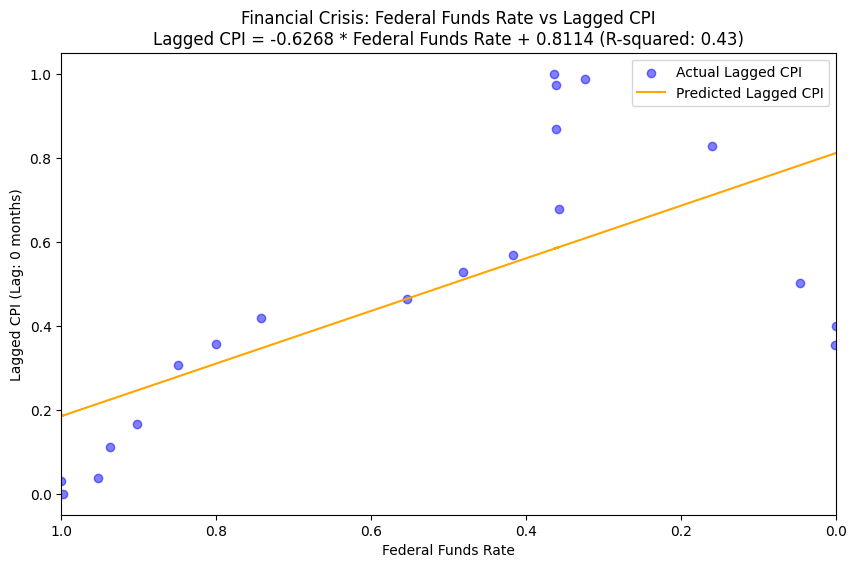

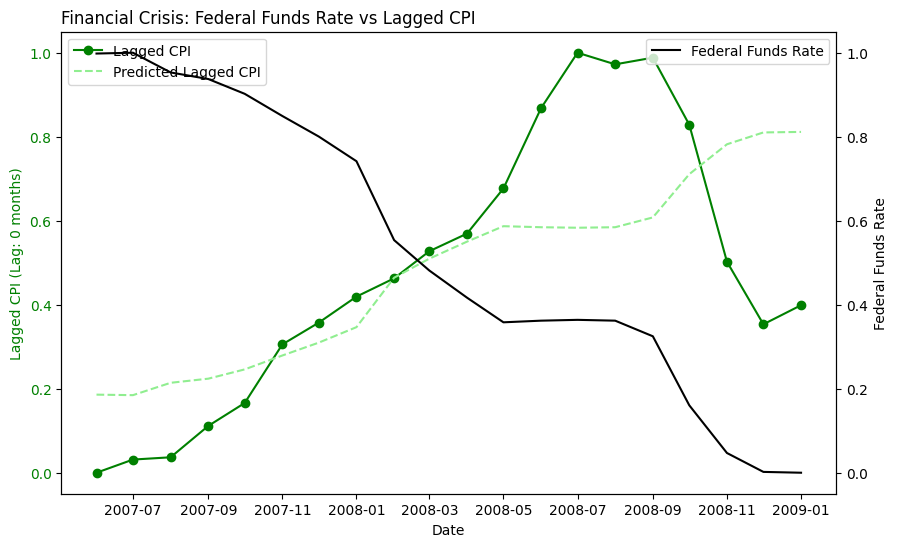

In [91]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
import yaml

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date for the data fetch
start_date = '2007-06-01'  # Preceding the financial crisis period
end_date = '2009-01-01'  # End date during the financial crisis period

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Smoothing function (adjust window size for moving average)
def smooth_data(data, window_size=9):
    return data.rolling(window=window_size).mean()

# Find the global maximum of a column (for FEDFUNDS)
def find_global_maximum(data, column_name):
    smoothed_data = smooth_data(data[column_name])
    global_max_idx = smoothed_data.idxmax()  # Find the index of the global maximum
    global_max_date = data.loc[global_max_idx, 'Date']  # Get the date of the global maximum
    print(f"Global maximum {column_name} occurred on: {global_max_date}")
    return global_max_date

# Find the global minimum of a column (for CPI)
def find_global_minimum(data, column_name):
    smoothed_data = smooth_data(data[column_name])
    global_min_idx = smoothed_data.idxmin()  # Find the index of the global minimum
    global_min_date = data.loc[global_min_idx, 'Date']  # Get the date of the global minimum
    print(f"Global minimum {column_name} occurred on: {global_min_date}")
    return global_min_date

# Apply a lag to CPI data
def create_lagged_cpi(data, lag):
    data['Lagged_CPI'] = data['CPI'].shift(lag)  # Apply lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Retrieve CPI and fed rate data
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # CPI data
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, fed_rate_df, on='Date')
merged_df.dropna(inplace=True)

# Normalize the CPI and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'FEDFUNDS']] = scaler.fit_transform(merged_df[['CPI', 'FEDFUNDS']])

# Step 1: Find the global maximum of the Fed Funds Rate and use that as the starting point
global_max_fed_date = find_global_maximum(merged_df, 'FEDFUNDS')
print(f"Global maximum of Fed Funds Rate occurred on: {global_max_fed_date}")

# Step 2: Now find the global minimum of CPI within the same time window
global_min_cpi_date = find_global_minimum(merged_df, 'CPI')
print(f"Global minimum of CPI occurred on: {global_min_cpi_date}")

# Step 3: Calculate the lag in months between the Fed Funds Rate peak and the CPI minimum
global_min_lag = (pd.to_datetime(global_min_cpi_date) - pd.to_datetime(global_max_fed_date)).days // 30
print(f"Global minimum lag is: {global_min_lag} months")

# Step 4: Apply the optimal lag to CPI data
lagged_data = create_lagged_cpi(merged_df, global_min_lag)

# Step 5: Perform the linear regression with the lagged CPI data
X = lagged_data[['FEDFUNDS']]
y = lagged_data['Lagged_CPI']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_[0]
intercept = model.intercept_

# Display the equation with variable names
equation = f"Lagged CPI = {coefficients:.4f} * Federal Funds Rate + {intercept:.4f}"
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)
print(f"R-squared: {r_squared:.4f}")

# Plot the scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Lagged CPI', color='blue', alpha=0.5)
plt.plot(X, y_pred, label='Predicted Lagged CPI', color='orange')
plt.xlabel('Federal Funds Rate')
plt.ylabel(f'Lagged CPI (Lag: {global_min_lag} months)')
plt.title(f'Financial Crisis: Federal Funds Rate vs Lagged CPI\n{equation} (R-squared: {r_squared:.2f})')
plt.legend()

# Set the x-axis limits from 1 to 0
plt.xlim(1, 0)

plt.show()

# Plot the time series of actual vs predicted lagged CPI with Fed Funds Rate on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the lagged CPI on the primary axis
ax1.plot(lagged_data['Date'], y, label='Lagged CPI', marker='o', color='green')
ax1.plot(lagged_data['Date'], y_pred, label='Predicted Lagged CPI', linestyle='--', color='lightgreen')
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Lagged CPI (Lag: {global_min_lag} months)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create a secondary axis for the Fed Funds Rate
ax2 = ax1.twinx()
ax2.plot(lagged_data['Date'], lagged_data['FEDFUNDS'], label='Federal Funds Rate', color='black')
ax2.set_ylabel('Federal Funds Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and legends
plt.title('Financial Crisis: Federal Funds Rate vs Lagged CPI', loc='left')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


Global maximum FEDFUNDS occurred on: 2000-12-01 00:00:00
Global maximum of Fed Funds Rate occurred on: 2000-12-01 00:00:00
Global maximum Unemployment Rate occurred on: 2002-12-01 00:00:00
Global maximum of Unemployment Rate occurred on: 2002-12-01 00:00:00
Global maximum lag is: 24 months
The linear model equation is:
Lagged Unemployment = 0.2038 * Federal Funds Rate + -0.0149 * CPI + 0.0892
R-squared: 0.7007


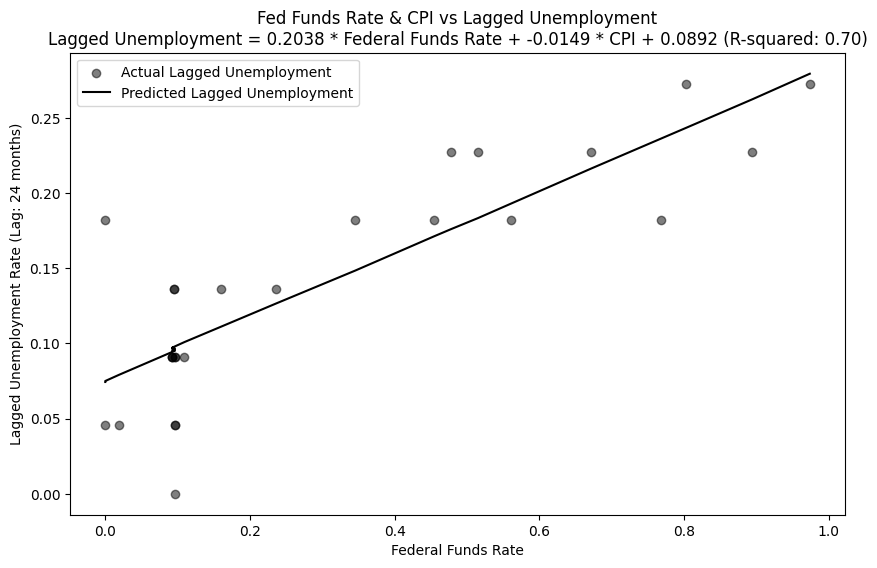

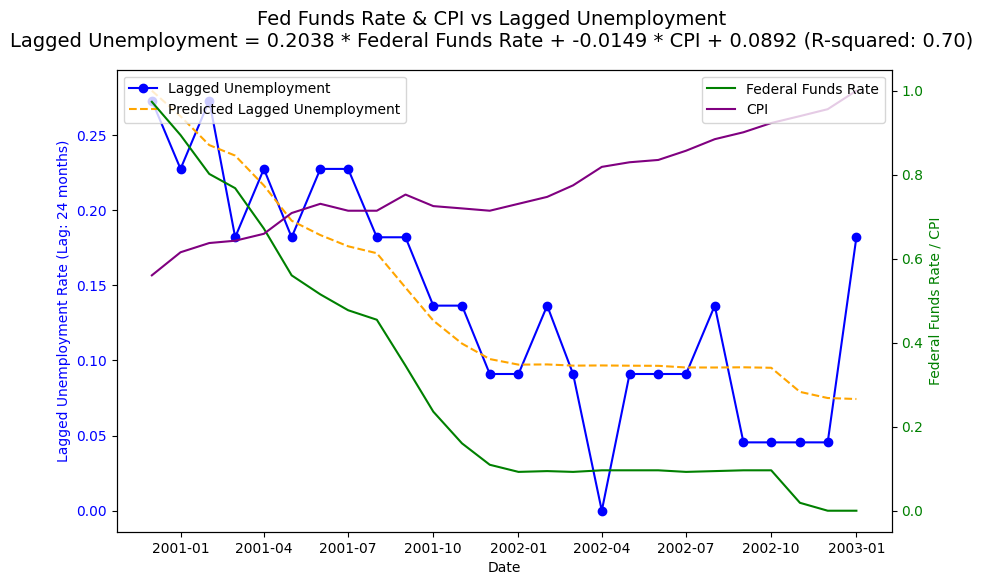

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
import yaml

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date for the data fetch
start_date = '1998-12-01'
end_date = '2003-01-01'

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Smoothing function (adjust window size for moving average)
def smooth_data(data, window_size=9):
    return data.rolling(window=window_size).mean()

# Directly find the global maximum of the unemployment or fed data within the provided date range
def find_global_maximum(data, column_name):
    smoothed_data = smooth_data(data[column_name])
    global_max_idx = smoothed_data.idxmax()  # Find the index of the global maximum
    global_max_date = data.loc[global_max_idx, 'Date']  # Get the date of the global maximum
    print(f"Global maximum {column_name} occurred on: {global_max_date}")
    return global_max_date

# Apply a lag to unemployment data
def create_lagged_unemployment(data, lag):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)  # Apply lag only to Unemployment Rate
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Retrieve unemployment, CPI, and fed rate data with the same time period
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # CPI data
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)

# Rename columns for clarity
unemployment_df.columns = ['Date', 'Unemployment Rate']
cpi_df.columns = ['Date', 'CPI']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column to ensure aligned time intervals
merged_df = pd.merge(unemployment_df, cpi_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')
merged_df.dropna(inplace=True)

# Normalize the Unemployment Rate, CPI, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['Unemployment Rate', 'CPI', 'FEDFUNDS']] = scaler.fit_transform(merged_df[['Unemployment Rate', 'CPI', 'FEDFUNDS']])

# Step 1: Find the global maximum of the Fed Funds Rate and use that as the starting point
global_max_fed_date = find_global_maximum(merged_df, 'FEDFUNDS')
print(f"Global maximum of Fed Funds Rate occurred on: {global_max_fed_date}")

# Step 2: Now find the global maximum of unemployment *within* the same time window
global_max_unemployment_date = find_global_maximum(merged_df, 'Unemployment Rate')
print(f"Global maximum of Unemployment Rate occurred on: {global_max_unemployment_date}")

# Step 3: Calculate the lag in months between the Fed Funds Rate peak and the Unemployment Rate peak
global_max_lag = (pd.to_datetime(global_max_unemployment_date) - pd.to_datetime(global_max_fed_date)).days // 30
print(f"Global maximum lag is: {global_max_lag} months")

lagged_data = create_lagged_unemployment(merged_df, global_max_lag)

# Step 5: Perform the multiple regression with the lagged unemployment data (CPI and Fed Funds Rate not lagged)
# Subset the DataFrame starting from the global_max_fed_date
X = lagged_data[lagged_data['Date'] >= global_max_fed_date][['FEDFUNDS', 'CPI']]
y = lagged_data['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Display the equation with variable names
equation = f"Lagged Unemployment = {coefficients[0]:.4f} * Federal Funds Rate + {coefficients[1]:.4f} * CPI + {intercept:.4f}"
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)
print(f"R-squared: {r_squared:.4f}")

# Plot the scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(X['FEDFUNDS'], y, label='Actual Lagged Unemployment', color='black', alpha=0.5)
plt.plot(X['FEDFUNDS'], y_pred, label='Predicted Lagged Unemployment', color='black')
plt.xlabel('Federal Funds Rate')
plt.ylabel(f'Lagged Unemployment Rate (Lag: {global_max_lag} months)')
plt.title(f'Fed Funds Rate & CPI vs Lagged Unemployment\n{equation} (R-squared: {r_squared:.2f})')
plt.legend()
plt.show()

# Plot the time series of actual vs predicted lagged unemployment with Fed Funds Rate and CPI on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the lagged unemployment on the primary axis
ax1.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o', color='blue')
ax1.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--', color='orange')
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Lagged Unemployment Rate (Lag: {global_max_lag} months)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary axis for the Fed Funds Rate and CPI (no lag)
ax2 = ax1.twinx()
ax2.plot(lagged_data['Date'], lagged_data['FEDFUNDS'], label='Federal Funds Rate', color='green')
ax2.plot(lagged_data['Date'], lagged_data['CPI'], label='CPI', color='purple')
ax2.set_ylabel('Federal Funds Rate / CPI', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Title and legends
fig.suptitle(f'Fed Funds Rate & CPI vs Lagged Unemployment\n{equation} (R-squared: {r_squared:.2f})', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


Global maximum unemployment rate occurred on: 2003-06-01 00:00:00
Global maximum lag is: 29 months
The linear model equation is:
Lagged Unemployment = 0.4749 * Federal Funds Rate + 0.4976


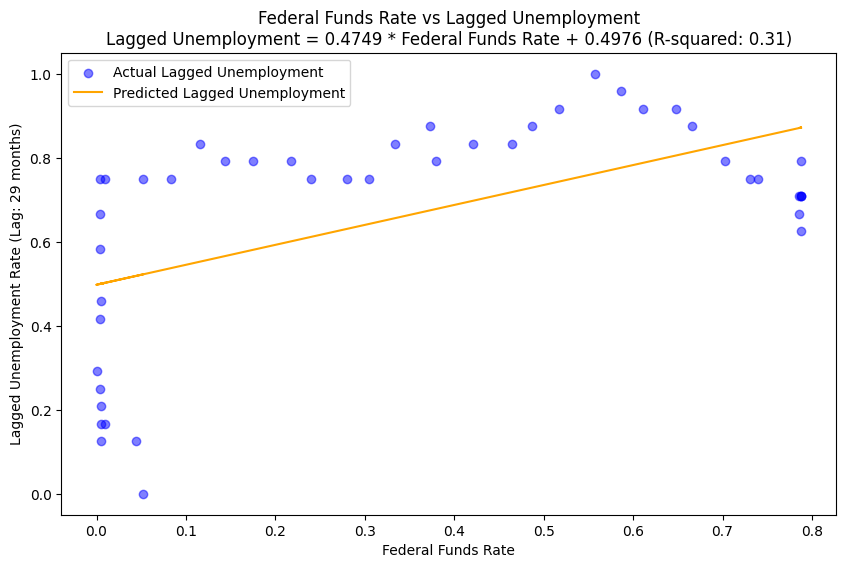

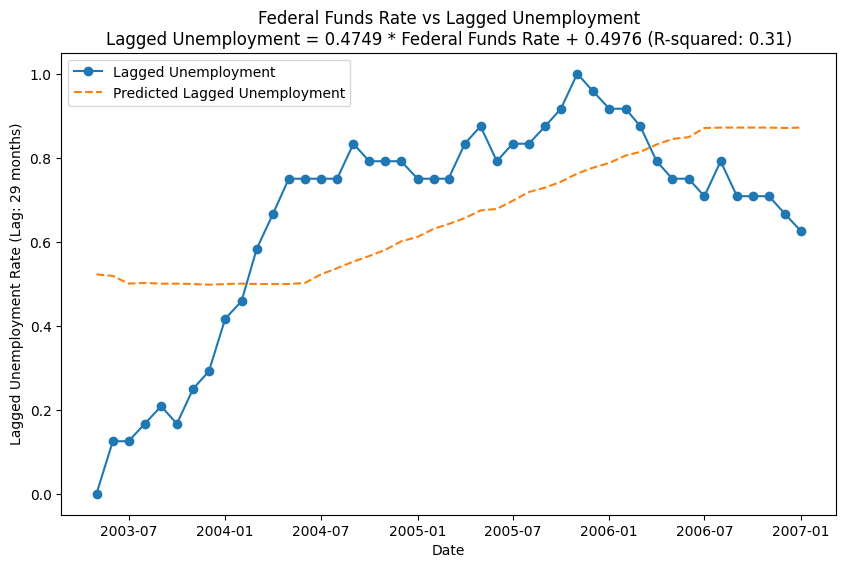

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import requests

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date
start_date = '2000-12-01'
end_date = '2007-01-01'

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Retrieve data from FRED API (starting from 2000-12-01 to 2007-01-01)
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(unemployment_df, fed_rate_df, on='Date')

# Drop any missing values (just in case)
merged_df.dropna(inplace=True)

# Normalize the Unemployment Rate and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(merged_df[['Unemployment Rate', 'FEDFUNDS']])

# Find the date of the global maximum unemployment rate after the start date
global_max_date = merged_df.loc[merged_df['Unemployment Rate'].idxmax(), 'Date']
print(f"Global maximum unemployment rate occurred on: {global_max_date}")

# Calculate the lag in months from the start date
days_difference = (global_max_date - pd.to_datetime(start_date)).days
global_max_lag = int(days_difference // 30.44)  # Convert to months
print(f"Global maximum lag is: {global_max_lag} months")

# Apply the global maximum lag to unemployment data
def create_lagged_unemployment(data, lag):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)  # Apply the lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Apply the lag corresponding to the global maximum to the unemployment data
lagged_data = create_lagged_unemployment(merged_df, global_max_lag)

# Perform the simple linear regression with the lagged unemployment data
X = lagged_data[['FEDFUNDS']]  # Independent variable: Federal Funds Rate
y = lagged_data['Lagged_Unemployment']  # Dependent variable: Lagged Unemployment Rate

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_[0]
intercept = model.intercept_

# Display the equation with variable names
equation = f"Lagged Unemployment = {coefficients:.4f} * Federal Funds Rate + {intercept:.4f}"
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)

# Plot the scatter and prediction curve
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Lagged Unemployment', color='blue', alpha=0.5)
plt.plot(X, y_pred, label='Predicted Lagged Unemployment', color='orange')
plt.xlabel('Federal Funds Rate')
plt.ylabel(f'Lagged Unemployment Rate (Lag: {global_max_lag} months)')
plt.title(f'Federal Funds Rate vs Lagged Unemployment\n{equation} (R-squared: {r_squared:.2f})')
plt.legend()
plt.show()

# Plot the time series of actual vs predicted lagged unemployment
plt.figure(figsize=(10, 6))
plt.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o')
plt.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--')
plt.xlabel('Date')
plt.ylabel(f'Lagged Unemployment Rate (Lag: {global_max_lag} months)')
plt.title(f'Federal Funds Rate vs Lagged Unemployment\n{equation} (R-squared: {r_squared:.2f})')
plt.legend()
plt.show()



## Multiple Linear regression using optimization to determine the lag parameter of unemployment with interaction term

To introduce an interaction term into the model, we need to create a new feature that is the interaction between CPI and Fed Funds Rate. The interaction term will capture any combined effect of these two variables on the lagged unemployment rate.

**Key Additions:**
1. **Interaction Term:** We create a new feature called CPI_FEDFUNDS_Interaction, which is the product of CPI and Fed Funds Rate. This term captures any combined effects of CPI and Fed Funds Rate on unemployment.
2. **Lag Optimization:** We still use scipy.optimize.minimize to find the optimal lag for unemployment. The optimization is based on minimizing the negative R-squared value, ensuring that the best lag is selected.
3. **Multiple Regression Model:** The model now includes the interaction term, along with CPI and Fed Funds Rate, as predictors.

**Output:**
* **Optimal Lag:** The optimization process will determine the best lag to use for the unemployment data.
* **R-Squared Value:** This will indicate how well the model, including the interaction term, fits the lagged unemployment data.
8 **Plot:** A line plot comparing the lagged unemployment data and the predicted unemployment based on the model. The plot helps visualize how well the model fits the lagged unemployment data.

This approach effectively uses both individual factors (CPI, Fed Funds Rate) and their interaction to explain unemployment, accounting for lagged effects.

**Interpretation of the Model Equation**

The regression equation does not fully capture the actual dynamics of the **Dot-Com period**. While it suggests that higher inflation and higher interest rates would decrease unemployment, the real-world scenario was more complex:
- The Fed cut rates aggressively during the bubble burst to combat rising unemployment, which the model doesn't fully capture.
- Inflation was low and stable during the period, and unemployment increased as the bubble burst, which contradicts the equation's assumption that higher inflation would lower unemployment.

In short, while the model may have a high R-squared value, its interpretation of CPI and Fed Funds Rate effects on unemployment doesn't align well with the economic reality of the Dot-Com Bubble burst.
Here's the updated code with the interaction term


<ipython-input-153-ad8c3d5ed8eb>:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(int(lag))  # Cast lag to integer
<ipython-input-153-ad8c3d5ed8eb>:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(int(lag))  # Cast lag to integer


Best lag found: 1 months
The linear model equation is:
Lagged Unemployment = -0.2243 * CPI + -0.8969 * FEDFUNDS + -1.1542 * CPI * FEDFUNDS + 1.0289


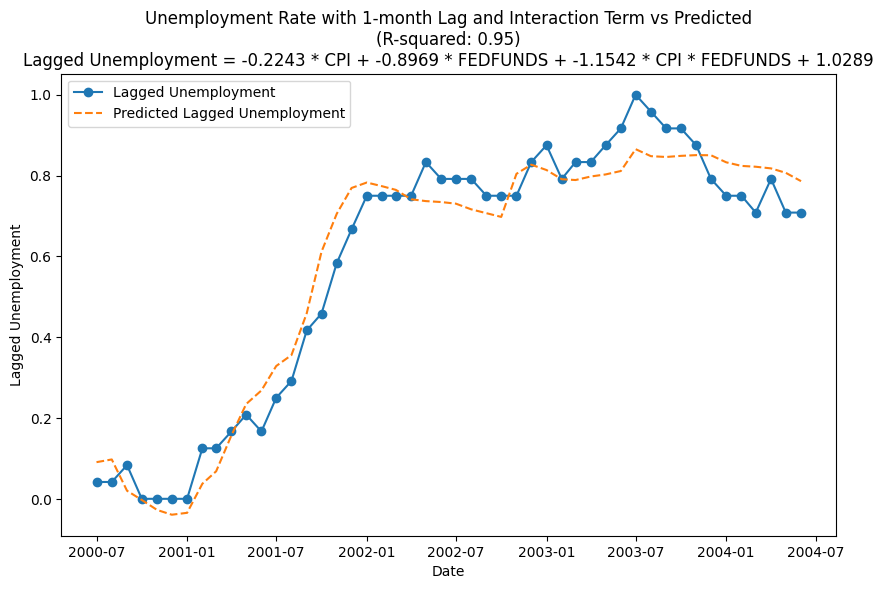

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import requests

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date='1998-01-01', end_date='2004-06-01'):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Set your FRED API key here
api_key = '7913092cb97545d7c236897b524805da'  # Replace with your actual FRED API key

# Retrieve data from FRED API (starting from 2000-06-01 to 2004-06-01)
start_date = '2000-06-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values (just in case)
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Add interaction term (CPI * FEDFUNDS)
merged_df['CPI_FEDFUNDS_Interaction'] = merged_df['CPI'] * merged_df['FEDFUNDS']

# Function to shift (lag) the unemployment rate by a given number of months
def create_lagged_unemployment(data, lag):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(int(lag))  # Cast lag to integer
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Function to compute R-squared for a given lag with the interaction term
def compute_r_squared(lag, data):
    lagged_data = create_lagged_unemployment(data.copy(), lag)
    X = lagged_data[['CPI', 'FEDFUNDS', 'CPI_FEDFUNDS_Interaction']]  # Include interaction term
    y = lagged_data['Lagged_Unemployment']  # Dependent variable (lagged unemployment)

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    return -r2_score(y, y_pred)  # We return negative R-squared to minimize

# Optimization to find the best lag
result = minimize(compute_r_squared, x0=1, args=(merged_df,), bounds=[(1, 12)], method='L-BFGS-B')

best_lag = int(result.x[0])  # Cast result to integer
print(f'Best lag found: {best_lag} months')

# Apply the best lag to the unemployment data
lagged_data = create_lagged_unemployment(merged_df, best_lag)

# Perform the multiple regression with the optimal lagged unemployment and interaction term
X = lagged_data[['CPI', 'FEDFUNDS', 'CPI_FEDFUNDS_Interaction']]
y = lagged_data['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Display the equation with variable names
equation = f"Lagged Unemployment = {coefficients[0]:.4f} * CPI + {coefficients[1]:.4f} * FEDFUNDS + {coefficients[2]:.4f} * CPI * FEDFUNDS + {intercept:.4f}"

# Print the equation
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o')
plt.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged Unemployment')
plt.title(f'Unemployment Rate with {best_lag}-month Lag and Interaction Term vs Predicted\n(R-squared: {r_squared:.2f})\n{equation}')
plt.legend()
plt.show()


## Modeling the Dot-com Bubble Burst with Multiple Linear Regression with unemployment lagged by 12 months (2000-06-01 to 2004-06-01)

The linear model equation is:
Lagged Unemployment = 1.2764 * CPI + -0.4721 * FEDFUNDS + -0.1791


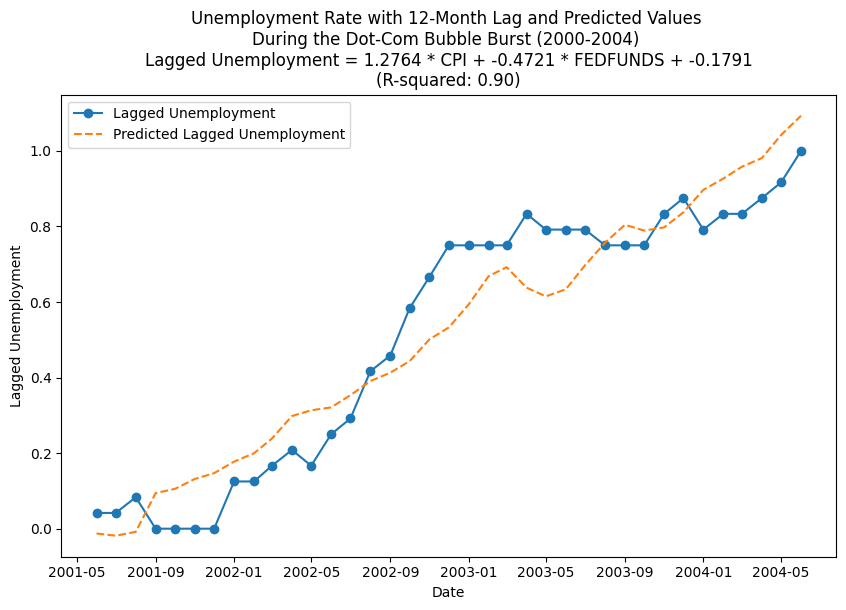

In [ ]:
# Retrieve data from FRED API (starting from 2000-06-01 to 2004-06-01)
start_date = '2000-06-01'
end_date = '2004-06-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Function to apply a 12-month lag to unemployment data
def create_lagged_unemployment(data, lag=12):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)  # Apply 12-month lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Apply the 12-month lag to the unemployment data
lagged_data = create_lagged_unemployment(merged_df)

# Perform the multiple regression with the lagged unemployment data
X = lagged_data[['CPI', 'FEDFUNDS']]
y = lagged_data['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Display the equation with variable names
equation = f"Lagged Unemployment = {coefficients[0]:.4f} * CPI + {coefficients[1]:.4f} * FEDFUNDS + {intercept:.4f}"

# Print the equation
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o')
plt.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged Unemployment')
plt.title(f'Unemployment Rate with 12-Month Lag and Predicted Values \nDuring the Dot-Com Bubble Burst (2000-2004) \n{equation}\n(R-squared: {r_squared:.2f})')
plt.legend()
plt.show()


## Multiple Linear Regression with lagged unemployment lagged by 12 months using interaction term between cpi and Fed Funds Rate

To introduce an interaction term in the multiple regression model, I included a term that multiplies two of the predictor variables (e.g., CPI and FEDFUNDS) and use this new term in the regression. Below is the code to include an interaction term between the CPI and FEDFUNDS variables:

**Key Additions:**
1. Interaction Term: The interaction term is created using lagged_data['CPI'] * lagged_data['FEDFUNDS'] and added as an additional predictor in the regression model.
2. Multiple Regression: The independent variables (CPI, FEDFUNDS, and their interaction) are used to predict the lagged unemployment data.
3. R-Squared: The R-squared value of the model is printed to evaluate how well the model explains the variance in the lagged unemployment data.

**Why Use an Interaction Term?**
The interaction term captures the effect of the joint relationship between CPI and Fed Funds Rate on unemployment. It shows how the relationship between unemployment and CPI might change depending on the level of the Fed Funds Rate, and vice versa.

This visualization and model will allow you to examine how the interaction between CPI and Fed Funds Rate might impact unemployment, especially with a 12-month lag.

**Interpretation of Model Equation:**

This result suggests that rising interest rates and inflation may have contributed to a reduction in unemployment during this period, though this inverse relationship may not be consistent across all periods or economic contexts.

The linear model equation is:
Lagged Unemployment = 1.3694 * CPI + -2.0278 * FEDFUNDS + 5.3257 * Interaction + -0.2980


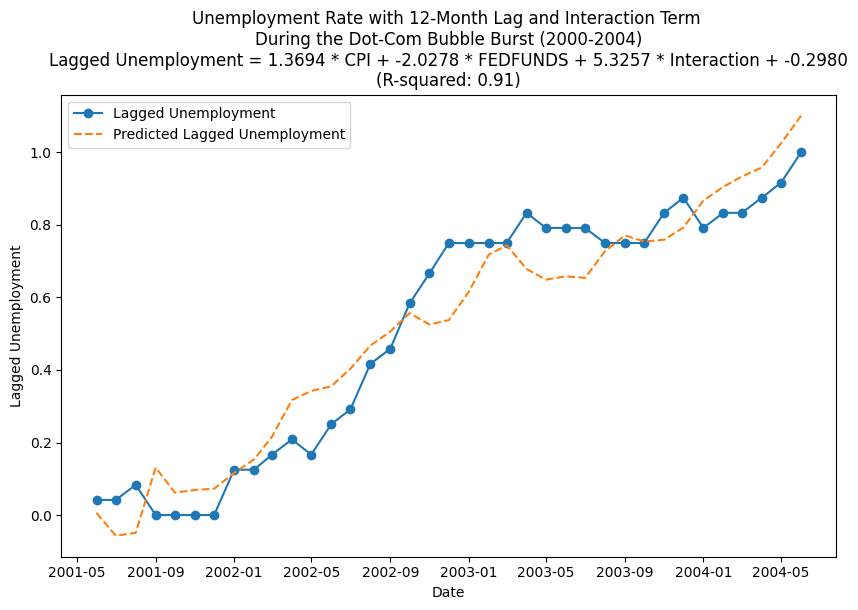

In [ ]:
# Retrieve data from FRED API (starting from 2000-06-01 to 2004-06-01)
start_date = '2000-06-01'
end_date = '2004-06-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Function to apply a 12-month lag to unemployment data
def create_lagged_unemployment(data, lag=12):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)  # Apply 12-month lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Apply the 12-month lag to the unemployment data
lagged_data = create_lagged_unemployment(merged_df)

# Create an interaction term between CPI and FEDFUNDS
lagged_data['CPI_FEDFUNDS_Interaction'] = lagged_data['CPI'] * lagged_data['FEDFUNDS']

# Perform the multiple regression with the lagged unemployment data and the interaction term
X = lagged_data[['CPI', 'FEDFUNDS', 'CPI_FEDFUNDS_Interaction']]
y = lagged_data['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Display the equation with variable names
equation = f"Lagged Unemployment = {coefficients[0]:.4f} * CPI + {coefficients[1]:.4f} * FEDFUNDS + {coefficients[2]:.4f} * Interaction + {intercept:.4f}"

# Print the equation
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o')
plt.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged Unemployment')
plt.title(f'Unemployment Rate with 12-Month Lag and Interaction Term \nDuring the Dot-Com Bubble Burst (2000-2004)\n{equation}\n(R-squared: {r_squared:.2f})')
plt.legend()
plt.show()


## Multiple Linear Regression incorporating an interaction term and optimize the lag for the unemployment data
To incorporate an interaction term and optimize the lag for the unemployment data in a multiple regression model, we need to perform the following steps:

* Define an optimization function to determine the best lag.
* Fit a multiple regression model using the lagged unemployment data and the interaction term.
* Find the optimal lag by minimizing a cost function, such as the negative R-squared value.

The updated process involves:

* Creating lagged unemployment data for different lags.
* Creating an interaction term between CPI and Fed Funds Rate.
* Optimizing the lag using an optimization algorithm (e.g., scipy.optimize.minimize).

Here’s the Python code that implements this:

**Key Changes:**
1. **Optimization of Lag:** We use the minimize function from scipy.optimize to find the optimal lag (between 1 and 12 months) by minimizing the negative R-squared value.
2. **Interaction Term:** An interaction term is created between CPI and FEDFUNDS and included in the multiple regression model.
3. **R-Squared Calculation:** The R-squared value is calculated to determine how well the model fits the data with the optimized lag.

**Explanation:**
* The interaction term (CPI * FEDFUNDS) captures how the combined effect of CPI and the Fed Funds Rate influences unemployment.
* The lag optimization ensures that we find the best delay between unemployment changes and the other predictors (CPI and Fed Funds Rate).
* R-squared helps evaluate how well the lagged model with the interaction term explains unemployment.

This model and visualization can be used to analyze the relationship between CPI, Fed Funds Rate, and unemployment over time, factoring in delayed effects.

**Interpretation of Model Equation:**

A reverse interpretation aligns with typical economic behavior, where higher unemployment can reduce inflationary pressures (lower demand) and prompt central banks to lower interest rates to stimulate economic activity.

<ipython-input-156-ad6b994e6f12>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)
<ipython-input-156-ad6b994e6f12>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)


Optimal Lag: 1 months
The linear model equation is:
Lagged Unemployment = -0.2587 * CPI + -0.8468 * Fed Funds Rate + -1.5204 * CPI * Fed Funds Rate + 1.0599


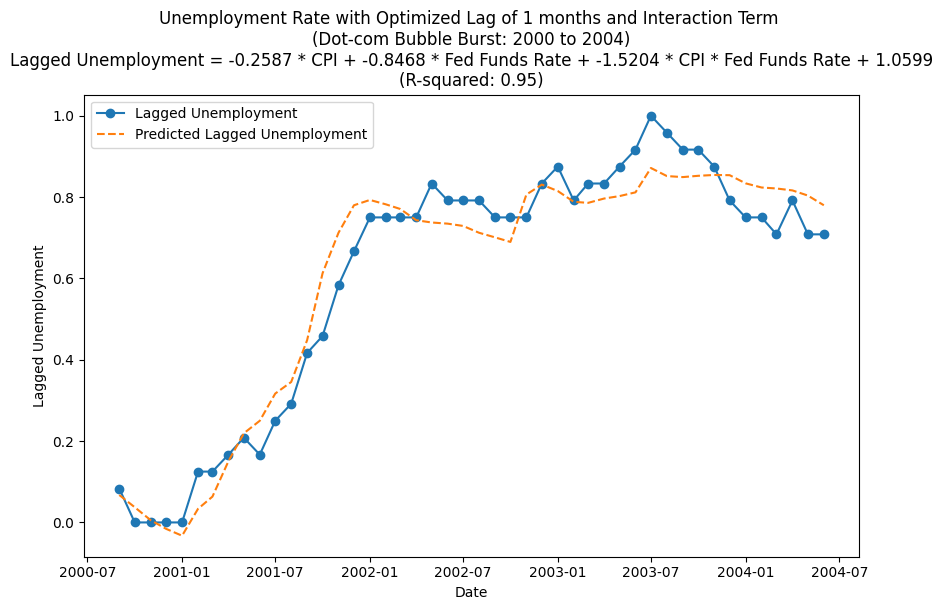

In [ ]:
# Retrieve data from FRED API (starting from 2000-06-01 to 2004-06-01)
start_date = '2000-06-01'
end_date = '2004-06-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values (just in case)
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Create an interaction term between CPI and FEDFUNDS
merged_df['CPI_FEDFUNDS_Interaction'] = merged_df['CPI'] * merged_df['FEDFUNDS']

# Function to apply a lag to unemployment data and calculate R-squared
def compute_r_squared(lag, data):
    lag = int(lag)
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging

    X = data[['CPI', 'FEDFUNDS', 'CPI_FEDFUNDS_Interaction']]
    y = data['Lagged_Unemployment']

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Return the negative R-squared to minimize
    return -r2_score(y, y_pred)

# Optimization to find the best lag (from 1 month to 12 months)
result = minimize(compute_r_squared, x0=1, args=(merged_df,), bounds=[(1, 12)], method='L-BFGS-B')

# Get the best lag value
best_lag = int(result.x[0])
print(f'Optimal Lag: {best_lag} months')

# Apply the best lag to the dataset
merged_df['Lagged_Unemployment'] = merged_df['Unemployment Rate'].shift(best_lag)
merged_df.dropna(inplace=True)

# Perform the multiple regression with the lagged unemployment data and the interaction term
X = merged_df[['CPI', 'FEDFUNDS', 'CPI_FEDFUNDS_Interaction']]
y = merged_df['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Display the equation with substituted variable names
equation = f"Lagged Unemployment = {coefficients[0]:.4f} * CPI + {coefficients[1]:.4f} * Fed Funds Rate + {coefficients[2]:.4f} * CPI * Fed Funds Rate + {intercept:.4f}"

# Print the equation
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], y, label='Lagged Unemployment', marker='o')
plt.plot(merged_df['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged Unemployment')
plt.title(f'Unemployment Rate with Optimized Lag of {best_lag} months and Interaction Term \n(Dot-com Bubble Burst: 2000 to 2004)\n{equation}\n(R-squared: {r_squared:.2f})')
plt.legend()
plt.show()


## Multiple Linear Regression Model of lagged CPI as Target Variable and unemployment and Fed Funds Rate as the explanatory variables
Here's how we can model lagged CPI as the target variable while keeping unemployment and Fed Funds Rate as the explanatory variables.

**Explanation:**
1. **Target Variable (CPI):** In this case, the model targets lagged CPI as the dependent variable.
2. **Explanatory Variables:** The independent variables are Unemployment Rate, Fed Funds Rate, and their interaction term (Unemployment Rate * Fed Funds Rate).
3. **Lag Optimization:** We use the minimize function from scipy.optimize to find the optimal lag for CPI.
4. **Multiple Regression:** Once the optimal lag is determined, a linear regression is performed using the interaction term as part of the model.
5. **Plot:** The plot shows the actual lagged CPI and the predicted values over time.

This setup allows us to understand how unemployment and the Fed Funds Rate affect future (lagged) inflation.

### **Interpretation of the Model Equation**

During the Dot-Com Bubble burst, the equation indicates that rising unemployment and increasing interest rates (Fed Funds Rate) both had strong deflationary effects, helping to suppress inflation. This aligns with the Fed's actions during this time, as they used rate hikes and other measures to counteract inflation while managing rising unemployment. The interaction term shows that the combined effect of these two variables significantly impacted inflation during the period.

<ipython-input-157-de8b15389abe>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)
<ipython-input-157-de8b15389abe>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)


Optimal Lag for CPI: 1 months
The linear model equation is:
Lagged CPI = -0.6851 * Unemployment Rate + -1.1861 * Fed Funds Rate + -1.5647 * (Unemployment Rate * Fed Funds Rate) + 1.3275


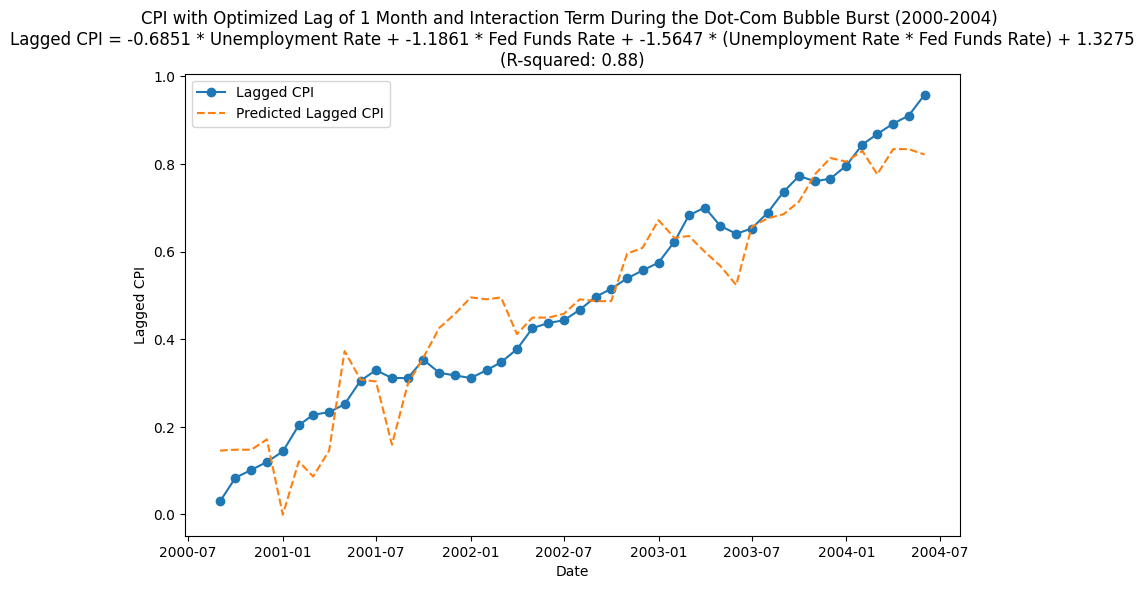

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import requests

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date='1998-01-01', end_date='2004-06-01'):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Set your FRED API key here
api_key = '7913092cb97545d7c236897b524805da'  # Replace with your actual FRED API key

# Retrieve data from FRED API (starting from 2000-06-01 to 2004-06-01)
start_date = '2000-06-01'
end_date = '2004-06-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Create an interaction term between Unemployment Rate and FEDFUNDS
merged_df['Unemployment_FEDFUNDS_Interaction'] = merged_df['Unemployment Rate'] * merged_df['FEDFUNDS']

# Function to apply a lag to CPI data and calculate R-squared
def compute_r_squared(lag, data):
    lag = int(lag)
    data['Lagged_CPI'] = data['CPI'].shift(lag)
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging

    X = data[['Unemployment Rate', 'FEDFUNDS', 'Unemployment_FEDFUNDS_Interaction']]
    y = data['Lagged_CPI']

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Return the negative R-squared to minimize
    return -r2_score(y, y_pred)

# Optimization to find the best lag (from 1 month to 12 months)
result = minimize(compute_r_squared, x0=1, args=(merged_df,), bounds=[(1, 12)], method='L-BFGS-B')

# Get the best lag value
best_lag = int(result.x[0])
print(f'Optimal Lag for CPI: {best_lag} months')

# Apply the best lag to the CPI data
merged_df['Lagged_CPI'] = merged_df['CPI'].shift(best_lag)
merged_df.dropna(inplace=True)

# Perform the multiple regression with the lagged CPI data and the interaction term
X = merged_df[['Unemployment Rate', 'FEDFUNDS', 'Unemployment_FEDFUNDS_Interaction']]
y = merged_df['Lagged_CPI']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Create the regression equation
equation = (f"Lagged CPI = {coefficients[0]:.4f} * Unemployment Rate "
            f"+ {coefficients[1]:.4f} * Fed Funds Rate "
            f"+ {coefficients[2]:.4f} * (Unemployment Rate * Fed Funds Rate) "
            f"+ {intercept:.4f}")

# Print the equation
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], y, label='Lagged CPI', marker='o')
plt.plot(merged_df['Date'], y_pred, label='Predicted Lagged CPI', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged CPI')
plt.title(f'CPI with Optimized Lag of {best_lag} Month and Interaction Term During the Dot-Com Bubble Burst (2000-2004) \n{equation}\n(R-squared: {r_squared:.2f})')
plt.legend()
plt.show()


## Multiple Linear Regression Model of lagged CPI as Target Variable and unemployment and Fed Funds Rate as the explanatory variables together with interaction between unemployment and Fed Funds Rate

### **Key Adjustments:**
1. **Target Variable**: The **lagged CPI** is used as the target variable (dependent variable).
2. **Explanatory Variables**: The explanatory variables are **Unemployment Rate**, **Fed Funds Rate**, and their interaction term.
3. **Lag Optimization**: The `minimize` function is used to determine the optimal lag for CPI (from 1 to 12 months).
4. **Multiple Regression**: Once the optimal lag for CPI is determined, the model is trained on the features and the lagged CPI.

This setup helps in analyzing how the unemployment rate and Fed Funds Rate (along with their interaction) affect future CPI values.

### **Key Finding:**
The interaction term has no impact on the model performance based on R-Squared

### **Interpretation of the model equation:**
In conclusion, during the period from 2000 to 2004, rising unemployment and higher federal funds rates contributed to a decrease in inflation, as captured by the model.

<ipython-input-158-5379ebb6098d>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)
<ipython-input-158-5379ebb6098d>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)


Optimal Lag for CPI: 1 months
The linear model equation is:
Lagged CPI = -0.6851 * Unemployment Rate + -1.1861 * Fed Funds Rate + -1.5647 * (Unemployment Rate * Fed Funds Rate) + 1.3275
R-squared of the model with interaction term and optimized lag: 0.88


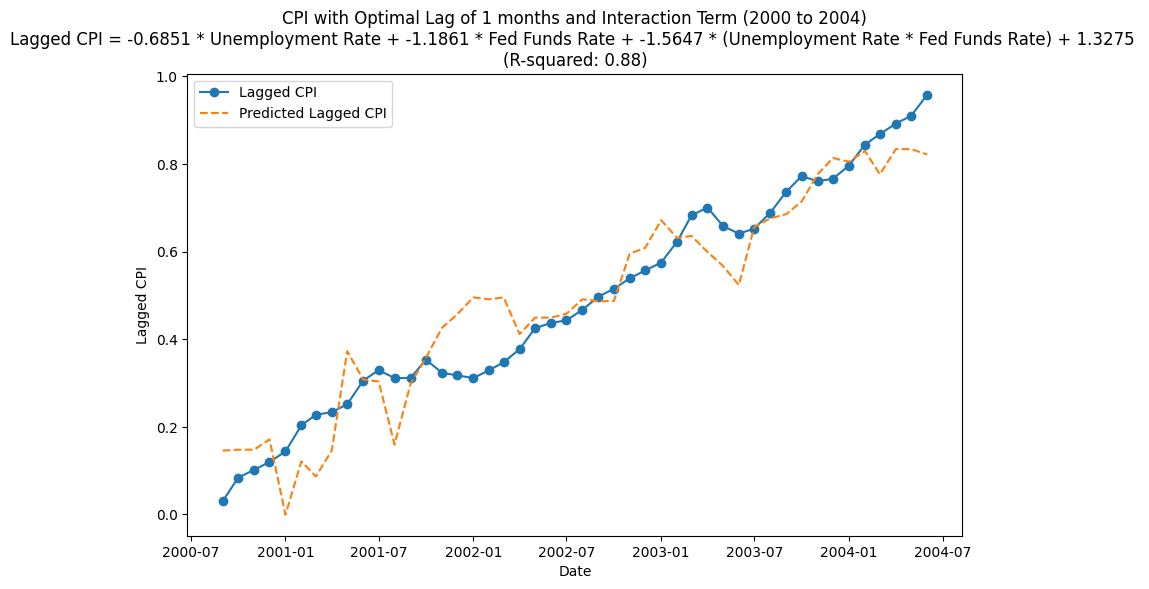

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
from scipy.optimize import minimize

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date='1998-01-01', end_date='2011-01-01'):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Set your FRED API key here
api_key = '7913092cb97545d7c236897b524805da'  # Replace with your actual FRED API key

# Retrieve data from FRED API (starting from 2000-06-01 to 2004-06-01)
start_date = '2000-06-01'
end_date = '2004-06-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Create an interaction term between Unemployment Rate and FEDFUNDS
merged_df['Unemployment_FEDFUNDS_Interaction'] = merged_df['Unemployment Rate'] * merged_df['FEDFUNDS']

# Function to apply a lag to CPI data and calculate R-squared
def compute_r_squared(lag, data):
    lag = int(lag)
    data['Lagged_CPI'] = data['CPI'].shift(lag)
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging

    X = data[['Unemployment Rate', 'FEDFUNDS', 'Unemployment_FEDFUNDS_Interaction']]
    y = data['Lagged_CPI']

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Return the negative R-squared to minimize
    return -r2_score(y, y_pred)

# Optimization to find the best lag (from 1 month to 12 months)
result = minimize(compute_r_squared, x0=1, args=(merged_df,), bounds=[(1, 12)], method='L-BFGS-B')

# Get the best lag value
best_lag = int(result.x[0])
print(f'Optimal Lag for CPI: {best_lag} months')

# Apply the best lag to the CPI data
merged_df['Lagged_CPI'] = merged_df['CPI'].shift(best_lag)
merged_df.dropna(inplace=True)

# Perform the multiple regression with the lagged CPI data and the interaction term
X = merged_df[['Unemployment Rate', 'FEDFUNDS', 'Unemployment_FEDFUNDS_Interaction']]
y = merged_df['Lagged_CPI']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_  # This gives you the array of coefficients (slopes)
intercept = model.intercept_  # This gives you the intercept (constant)

# Calculate R-squared value
r_squared = r2_score(y, y_pred)

# Construct the equation
equation = f"Lagged CPI = {coefficients[0]:.4f} * Unemployment Rate + {coefficients[1]:.4f} * Fed Funds Rate + {coefficients[2]:.4f} * (Unemployment Rate * Fed Funds Rate) + {intercept:.4f}"

# Print the equation
print(f"The linear model equation is:\n{equation}")

# Print the R-squared value of the model
print(f'R-squared of the model with interaction term and optimized lag: {r_squared:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], y, label='Lagged CPI', marker='o')
plt.plot(merged_df['Date'], y_pred, label='Predicted Lagged CPI', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged CPI')
plt.title(f'CPI with Optimal Lag of {best_lag} months and Interaction Term (2000 to 2004)\n{equation} \n(R-squared: {r_squared:.2f})')
plt.legend()
plt.show()


In [ ]:
# Define color scheme based on time periods
def rate_color_map(date):
    if date >= pd.to_datetime("1999-01-01") and date <= pd.to_datetime("2000-06-01"):
        return 'red'
    elif date >= pd.to_datetime("2000-06-01") and date <= pd.to_datetime("2003-06-01"):
        return 'green'
    elif date >= pd.to_datetime("2004-06-01") and date <= pd.to_datetime("2006-06-01"):
        return 'red'
    elif date >= pd.to_datetime("2007-06-01") and date <= pd.to_datetime("2009-01-01"):
        return 'green'
    elif date >= pd.to_datetime("2015-11-01") and date <= pd.to_datetime("2019-06-01"):
        return 'red'
    elif date >= pd.to_datetime("2019-07-01") and date <= pd.to_datetime("2020-03-01"):
        return 'green'
    elif date >= pd.to_datetime("2022-02-01") and date <= pd.to_datetime("2023-06-01"):
        return 'red'
    else:
        return 'grey'

## Modeling the Financial Crisis with Multiple Linear Regression with unemployment lagged by 12 months (2007-06-01 to 2011-01-01)

Using the time interval from **June 2007** to **January 2011**, which includes the **Global Financial Crisis (GFC)** and the subsequent recovery period, can provide important insights for policymakers regarding the effects of monetary policy, particularly interest rate changes, on inflation and unemployment. During this period, the U.S. experienced significant economic turbulence, including rapid increases in unemployment and deflationary pressures, followed by a period of low interest rates aimed at stimulating recovery.

### Insights for Policymakers

- **Impact of Monetary Policy**: During this period, the Federal Reserve aggressively cut interest rates in response to the GFC. The data allows policymakers to observe how quickly unemployment responded to rate cuts, and whether there was a lagged effect between changes in the Fed Funds Rate and reductions in unemployment.
  
- **Lagged Response of Unemployment**: By introducing a 12-month lag to the unemployment data, the model shows that unemployment may not immediately respond to changes in interest rates. Policymakers can assess whether the recovery in employment lagged behind monetary stimulus actions, which can be important in deciding the timing and magnitude of rate cuts or hikes.

- **Trade-offs Between Inflation and Unemployment**: The plot and model allow policymakers to explore the relationship between inflation (CPI) and unemployment, informing whether the Fed was able to strike a balance between the two. If inflation remained subdued while unemployment decreased, this would indicate the Fed successfully maintained the dual mandate. However, if inflation began rising with unemployment reductions, it could signal a trade-off between the two.

This period is crucial for evaluating the effectiveness of the Fed’s response to a major economic crisis, offering insights into how interest rate cuts influenced both inflation and unemployment over time.


Here's the analysis using this time frame:

### **Interpretation of the model equation:**
In conclusion, during the 2007-2011 Global Financial Crisis, inflation increased unemployment significantly, while higher interest rates were associated with reduced unemployment. The overall model provides a solid fit for explaining unemployment based on these factors.

The linear model equation is:
Lagged Unemployment = 1.7210 * CPI + -2.3379 * Fed Funds Rate + -0.5594
R-squared of the model with 12-month lag: 0.84


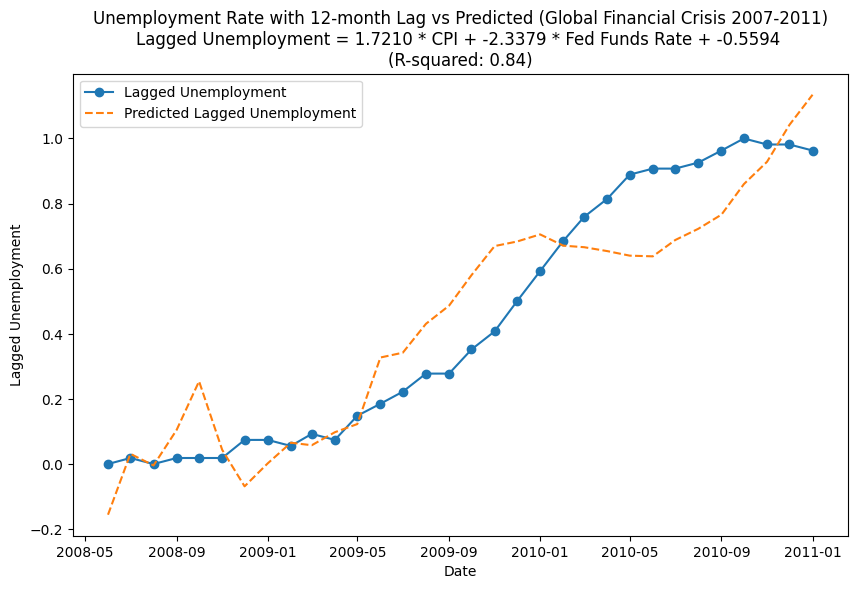

In [ ]:
# Retrieve data from FRED API (starting from 2007-06-01 to 2011-01-01)
start_date = '2007-06-01'
end_date = '2011-01-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values (just in case)
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Function to apply a 12-month lag to unemployment data
def create_lagged_unemployment(data, lag=12):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)  # Apply 12-month lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Apply the 12-month lag to the unemployment data
lagged_data = create_lagged_unemployment(merged_df)

# Perform the multiple regression with the lagged unemployment data
X = lagged_data[['CPI', 'FEDFUNDS']]
y = lagged_data['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_  # This gives you the array of coefficients (slopes)
intercept = model.intercept_  # This gives you the intercept (constant)

# Calculate R-squared value
r_squared = r2_score(y, y_pred)

# Construct the equation
equation = f"Lagged Unemployment = {coefficients[0]:.4f} * CPI + {coefficients[1]:.4f} * Fed Funds Rate + {intercept:.4f}"

# Print the equation
print(f"The linear model equation is:\n{equation}")

# Print the R-squared value of the model
print(f'R-squared of the model with 12-month lag: {r_squared:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o')
plt.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged Unemployment')
plt.title(f'Unemployment Rate with 12-month Lag vs Predicted (Global Financial Crisis 2007-2011)\n{equation} \n(R-squared: {r_squared:.2f})')
plt.legend()
plt.show()


## Modeling the Financial Crisis with Multiple Linear Regression with unemployment lagged by 12 months and introduction of interaction term (2007 to 2011)

To adapt the code for the use of an **interaction term** between CPI and FEDFUNDS while retaining the 12-month lag for unemployment, here’s the modified code:

1. We'll add the interaction term between CPI and FEDFUNDS in the regression model.
2. We will use the same process of lagging the unemployment data by 12 months.
3. Then, the regression will include CPI, FEDFUNDS, and their interaction term as the explanatory variables.

### **Explanation of Key Changes:**
1. **Interaction Term**: We introduce an interaction term between CPI and FEDFUNDS as `CPI_FEDFUNDS_Interaction = CPI * FEDFUNDS` and include it in the regression model.
2. **Lagged Unemployment**: A 12-month lag is applied to the unemployment data, shifting it back to ensure we're predicting the lagged unemployment based on past CPI and FEDFUNDS data.
3. **Modeling**: We perform linear regression using CPI, FEDFUNDS, and their interaction term as independent variables, with the lagged unemployment as the dependent variable.

### **Interpretation:**
This approach aims to determine the combined effects of inflation (CPI), interest rates (FEDFUNDS), and their interaction on unemployment over the given time period, helping policymakers understand how these factors influence employment outcomes during and after the **2008 Financial Crisis**.

### **Key Findings:**
The interaction term did have no impact on the models performance.

### **Interpretation of the model equation:**
In summary, this model suggests that inflation increases unemployment, while interest rate hikes decrease it, and their combined effect is more nuanced, reducing unemployment further when they both increase together.

R-squared of the model with interaction term: 0.84
Regression Equation: Lagged Unemployment = 1.7408 * CPI + -1.5284 * FEDFUNDS + -1.0131 * (CPI * FEDFUNDS) + -0.5747


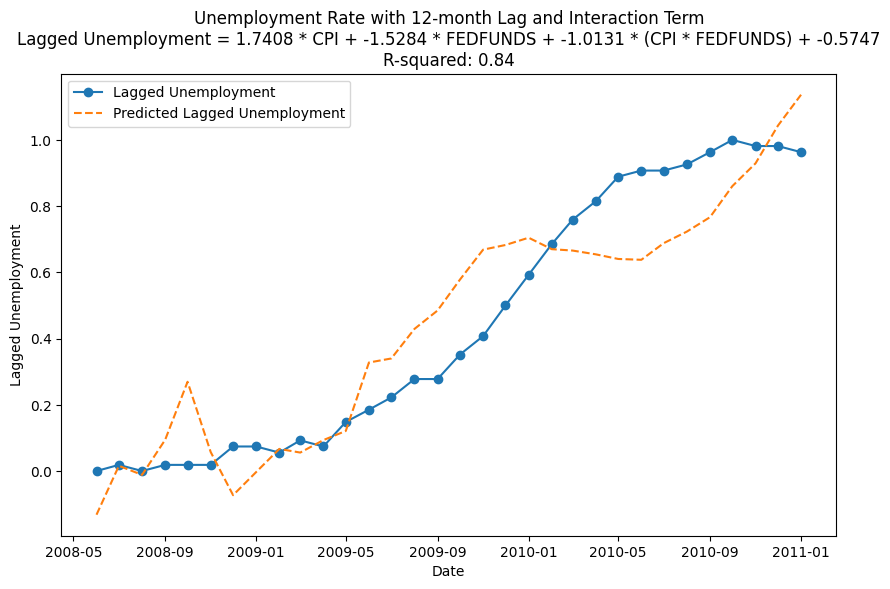

In [ ]:
# Retrieve data from FRED API (starting from 2007-06-01 to 2011-01-01)
start_date = '2007-06-01'
end_date = '2011-01-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values (just in case)
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Function to apply a 12-month lag to unemployment data
def create_lagged_unemployment(data, lag=12):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)  # Apply 12-month lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Apply the 12-month lag to the unemployment data
lagged_data = create_lagged_unemployment(merged_df)

# Create an interaction term between CPI and FEDFUNDS
lagged_data['CPI_FEDFUNDS_Interaction'] = lagged_data['CPI'] * lagged_data['FEDFUNDS']

# Perform the multiple regression with the lagged unemployment data and the interaction term
X = lagged_data[['CPI', 'FEDFUNDS', 'CPI_FEDFUNDS_Interaction']]
y = lagged_data['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Get the coefficients and intercept for the equation
coefficients = model.coef_
intercept = model.intercept_

# Construct the regression equation
equation = f"Lagged Unemployment = {coefficients[0]:.4f} * CPI + {coefficients[1]:.4f} * FEDFUNDS + {coefficients[2]:.4f} * (CPI * FEDFUNDS) + {intercept:.4f}"

# Get the R-squared value
r_squared = r2_score(y, y_pred)

# Print the R-squared value and equation
print(f'R-squared of the model with interaction term: {r_squared:.2f}')
print(f"Regression Equation: {equation}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o')
plt.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged Unemployment')
plt.title(f'Unemployment Rate with 12-month Lag and Interaction Term\n{equation}\nR-squared: {r_squared:.2f}')
plt.legend()
plt.show()


## Modeling the Financial Crisis with Multiple Linear Regression with unemployment lagged, introduce interaction term with lag determined through optimization (2007 to 2011)

We modified the previous approach to include **lag optimization** for unemployment, we need to optimize the lag (using a method like `minimize` from `scipy.optimize`) to maximize the model's performance. The goal is to find the best lag (in months) that gives the highest R-squared value for the regression model, which includes an interaction term between CPI and FEDFUNDS.

### Explanation of Key Additions:
1. **Optimization Function (`compute_r_squared`)**: This function takes a lag value, applies the lag to unemployment, and returns the negative R-squared value of the regression model. This negative value is minimized to maximize the R-squared value.
   
2. **Optimization**: The `minimize` function from `scipy.optimize` is used to determine the best lag between 1 and 12 months by minimizing the negative R-squared value.

3. **Best Lag Application**: Once the optimal lag is determined, it is applied to the unemployment data, and the regression is re-run with the interaction term included.

4. **Plot**: The results are plotted, showing both the actual lagged unemployment data and the predicted values from the model.

### Interpretation:
By optimizing the lag period for unemployment data, this approach finds the time delay between changes in CPI, FEDFUNDS, and their interaction that best explains unemployment during the time of the **Global Financial Crisis** (2007 to 2011).

### Key Findings


<ipython-input-162-8dc7323e16ce>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)
<ipython-input-162-8dc7323e16ce>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)


Optimal Lag: 1 months
R-squared of the model with interaction term and optimized lag: 0.91
Regression Equation: Lagged Unemployment = 0.6957 * CPI + -0.1343 * Fed Funds Rate + -2.5139 * (CPI * Fed Funds Rate) + 0.4075


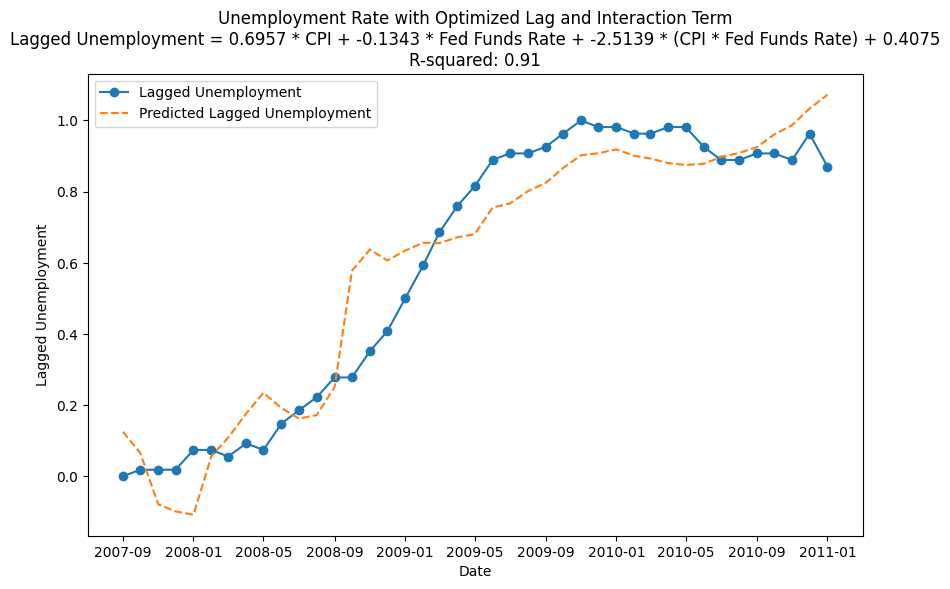

In [ ]:
# Retrieve data from FRED API (starting from 2007-06-01 to 2011-01-01)
start_date = '2007-06-01'
end_date = '2011-01-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values (just in case)
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Create an interaction term between CPI and FEDFUNDS
merged_df['CPI_FEDFUNDS_Interaction'] = merged_df['CPI'] * merged_df['FEDFUNDS']

# Function to apply a lag to unemployment data and calculate R-squared
def compute_r_squared(lag, data):
    lag = int(lag)
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)  # Apply the lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging

    # Prepare the data for regression
    X = data[['CPI', 'FEDFUNDS', 'CPI_FEDFUNDS_Interaction']]
    y = data['Lagged_Unemployment']

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Return the negative R-squared value (we minimize this value)
    return -r2_score(y, y_pred)

# Optimization to find the best lag (from 1 month to 12 months)
result = minimize(compute_r_squared, x0=1, args=(merged_df,), bounds=[(1, 12)], method='L-BFGS-B')

# Get the best lag value
best_lag = int(result.x[0])
print(f'Optimal Lag: {best_lag} months')

# Apply the best lag to the dataset
merged_df['Lagged_Unemployment'] = merged_df['Unemployment Rate'].shift(best_lag)
merged_df.dropna(inplace=True)

# Perform the multiple regression with the lagged unemployment data and the interaction term
X = merged_df[['CPI', 'FEDFUNDS', 'CPI_FEDFUNDS_Interaction']]
y = merged_df['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Get the coefficients and intercept for the regression equation
coefficients = model.coef_
intercept = model.intercept_

# Construct the regression equation
equation = f"Lagged Unemployment = {coefficients[0]:.4f} * CPI + {coefficients[1]:.4f} * Fed Funds Rate + {coefficients[2]:.4f} * (CPI * Fed Funds Rate) + {intercept:.4f}"

# Get the R-squared value
r_squared = r2_score(y, y_pred)

# Print the R-squared value and equation
print(f'R-squared of the model with interaction term and optimized lag: {r_squared:.2f}')
print(f"Regression Equation: {equation}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], y, label='Lagged Unemployment', marker='o')
plt.plot(merged_df['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged Unemployment')
plt.title(f'Unemployment Rate with Optimized Lag and Interaction Term\n{equation}\nR-squared: {r_squared:.2f}')
plt.legend()
plt.show()


## Multiple Linear Regression Model of lagged CPI as Target Variable and unemployment and Fed Funds Rate as the explanatory variables together with interaction between unemployment and Fed Funds Rate

<ipython-input-163-118f27d6e655>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)
<ipython-input-163-118f27d6e655>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)


Optimal Lag for CPI: 1 months
The linear model equation is:
Lagged CPI = 0.3839 * Unemployment Rate + -0.3254 * Fed Funds Rate + 6.1144 * (Unemployment Rate * Fed Funds Rate) + 0.2483
R-squared of the model with interaction term and optimized lag: 0.66


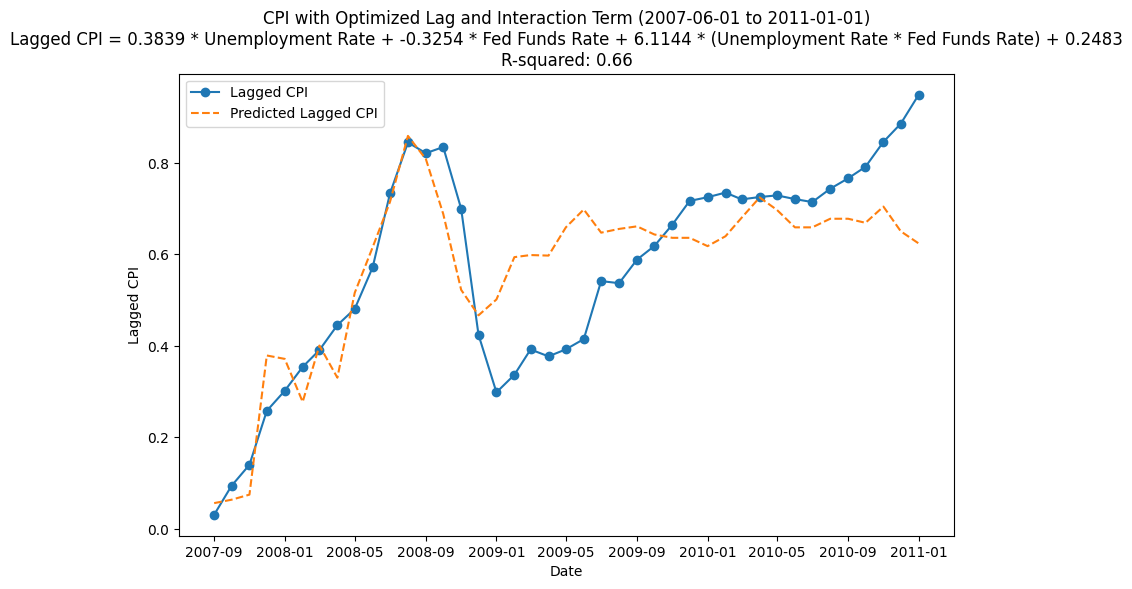

In [ ]:

# Retrieve data from FRED API (starting from 2007-06-01 to 2011-01-01)
start_date = '2007-06-01'
end_date = '2011-01-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Create an interaction term between Unemployment Rate and FEDFUNDS
merged_df['Unemployment_FEDFUNDS_Interaction'] = merged_df['Unemployment Rate'] * merged_df['FEDFUNDS']

# Function to apply a lag to CPI data and calculate R-squared
def compute_r_squared(lag, data):
    lag = int(lag)
    data['Lagged_CPI'] = data['CPI'].shift(lag)
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging

    X = data[['Unemployment Rate', 'FEDFUNDS', 'Unemployment_FEDFUNDS_Interaction']]
    y = data['Lagged_CPI']

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Return the negative R-squared to minimize
    return -r2_score(y, y_pred)

# Optimization to find the best lag (from 1 month to 12 months)
result = minimize(compute_r_squared, x0=1, args=(merged_df,), bounds=[(1, 12)], method='L-BFGS-B')

# Get the best lag value
best_lag = int(result.x[0])
print(f'Optimal Lag for CPI: {best_lag} months')

# Apply the best lag to the CPI data
merged_df['Lagged_CPI'] = merged_df['CPI'].shift(best_lag)
merged_df.dropna(inplace=True)

# Perform the multiple regression with the lagged CPI data and the interaction term
X = merged_df[['Unemployment Rate', 'FEDFUNDS', 'Unemployment_FEDFUNDS_Interaction']]
y = merged_df['Lagged_CPI']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_  # This gives you the array of coefficients (slopes)
intercept = model.intercept_  # This gives you the intercept (constant)

# Construct the regression equation
equation = f"Lagged CPI = {coefficients[0]:.4f} * Unemployment Rate + {coefficients[1]:.4f} * Fed Funds Rate + {coefficients[2]:.4f} * (Unemployment Rate * Fed Funds Rate) + {intercept:.4f}"

# Print the equation
print(f"The linear model equation is:\n{equation}")

# Print the R-squared value of the model
r_squared = r2_score(y, y_pred)
print(f'R-squared of the model with interaction term and optimized lag: {r_squared:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], y, label='Lagged CPI', marker='o')
plt.plot(merged_df['Date'], y_pred, label='Predicted Lagged CPI', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged CPI')
plt.title(f'CPI with Optimized Lag and Interaction Term (2007-06-01 to 2011-01-01)\n{equation}\nR-squared: {r_squared:.2f}')
plt.legend()
plt.show()


<ipython-input-164-7471469effe0>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)
<ipython-input-164-7471469effe0>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)


Optimal Lag for CPI: 1 months
The linear model equation is:
Lagged CPI = 0.3839 * Unemployment Rate + -0.3254 * Fed Funds Rate + 6.1144 * (Unemployment Rate * Fed Funds Rate) + 0.2483
R-squared of the model with interaction term and optimized lag: 0.66


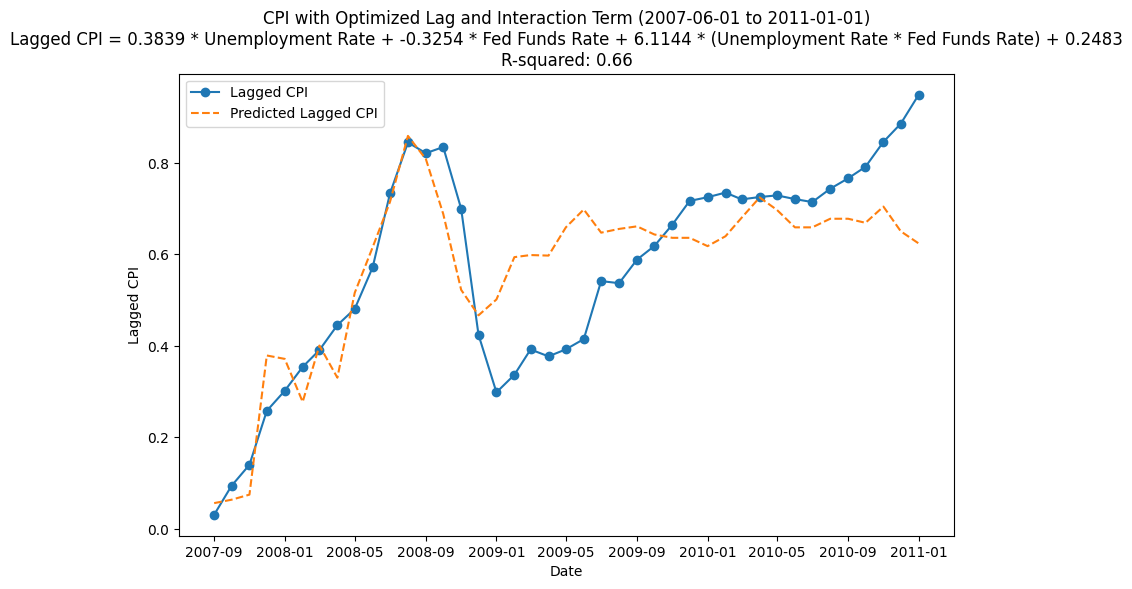

In [ ]:
# Retrieve data from FRED API for the Financial Crisis period (2007-06-01 to 2011-01-01)
start_date = '2007-06-01'
end_date = '2011-01-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Create an interaction term between Unemployment Rate and FEDFUNDS
merged_df['Unemployment_FEDFUNDS_Interaction'] = merged_df['Unemployment Rate'] * merged_df['FEDFUNDS']

# Function to apply a lag to CPI data and calculate R-squared
def compute_r_squared(lag, data):
    lag = int(lag)
    data['Lagged_CPI'] = data['CPI'].shift(lag)
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging

    X = data[['Unemployment Rate', 'FEDFUNDS', 'Unemployment_FEDFUNDS_Interaction']]
    y = data['Lagged_CPI']

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Return the negative R-squared to minimize
    return -r2_score(y, y_pred)

# Optimization to find the best lag (from 1 month to 12 months)
result = minimize(compute_r_squared, x0=1, args=(merged_df,), bounds=[(1, 12)], method='L-BFGS-B')

# Get the best lag value
best_lag = int(result.x[0])
print(f'Optimal Lag for CPI: {best_lag} months')

# Apply the best lag to the CPI data
merged_df['Lagged_CPI'] = merged_df['CPI'].shift(best_lag)
merged_df.dropna(inplace=True)

# Perform the multiple regression with the lagged CPI data and the interaction term
X = merged_df[['Unemployment Rate', 'FEDFUNDS', 'Unemployment_FEDFUNDS_Interaction']]
y = merged_df['Lagged_CPI']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_  # This gives you the array of coefficients (slopes)
intercept = model.intercept_  # This gives you the intercept (constant)

# Construct the regression equation
equation = f"Lagged CPI = {coefficients[0]:.4f} * Unemployment Rate + {coefficients[1]:.4f} * Fed Funds Rate + {coefficients[2]:.4f} * (Unemployment Rate * Fed Funds Rate) + {intercept:.4f}"

# Print the equation
print(f"The linear model equation is:\n{equation}")

# Print the R-squared value of the model
r_squared = r2_score(y, y_pred)
print(f'R-squared of the model with interaction term and optimized lag: {r_squared:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], y, label='Lagged CPI', marker='o')
plt.plot(merged_df['Date'], y_pred, label='Predicted Lagged CPI', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged CPI')
plt.title(f'CPI with Optimized Lag and Interaction Term (2007-06-01 to 2011-01-01)\n{equation}\nR-squared: {r_squared:.2f}')
plt.legend()
plt.show()


R-squared of the model with interaction term and 12-month lag: 0.6178045714880138


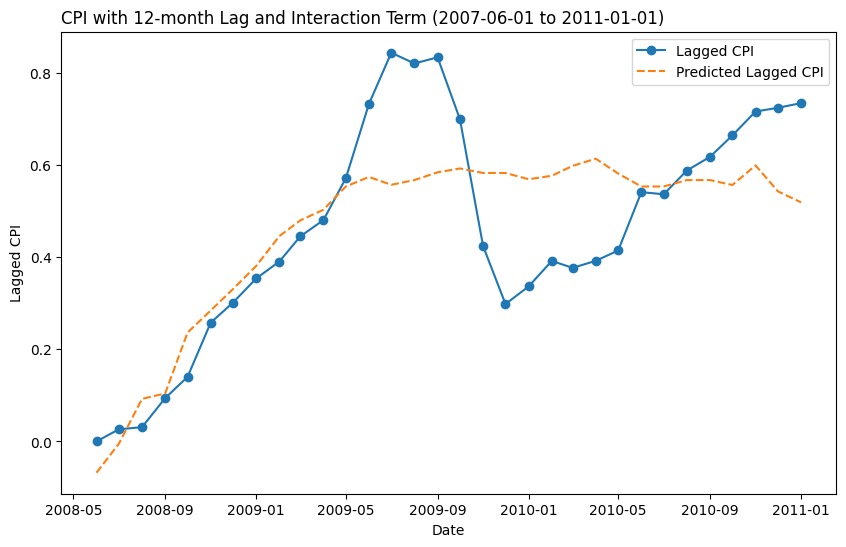

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date='1998-01-01', end_date='2024-09-01'):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Set your FRED API key here
api_key = '7913092cb97545d7c236897b524805da'  # Replace with your actual FRED API key

# Retrieve data from FRED API for the Financial Crisis period (2007-06-01 to 2011-01-01)
start_date = '2007-06-01'
end_date = '2011-01-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Create an interaction term between Unemployment Rate and FEDFUNDS
merged_df['Unemployment_FEDFUNDS_Interaction'] = merged_df['Unemployment Rate'] * merged_df['FEDFUNDS']

# Apply a fixed 12-month lag to the CPI data
def apply_12_month_lag(data):
    data['Lagged_CPI'] = data['CPI'].shift(12)
    data.dropna(inplace=True)
    return data

# Apply the 12-month lag to the CPI data
lagged_data = apply_12_month_lag(merged_df)

# Perform the multiple regression with the lagged CPI data and the interaction term
X = lagged_data[['Unemployment Rate', 'FEDFUNDS', 'Unemployment_FEDFUNDS_Interaction']]
y = lagged_data['Lagged_CPI']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Print the R-squared value of the model
r2 = r2_score(y, y_pred)
print(f'R-squared of the model with interaction term and 12-month lag: {r2}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lagged_data['Date'], y, label='Lagged CPI', marker='o')
plt.plot(lagged_data['Date'], y_pred, label='Predicted Lagged CPI', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged CPI')
plt.title(f'CPI with 12-month Lag and Interaction Term (2007-06-01 to 2011-01-01)', loc='left')
plt.legend()
plt.show()


R-squared of the model with no interaction term and 12-month lag: 0.6096219193766852


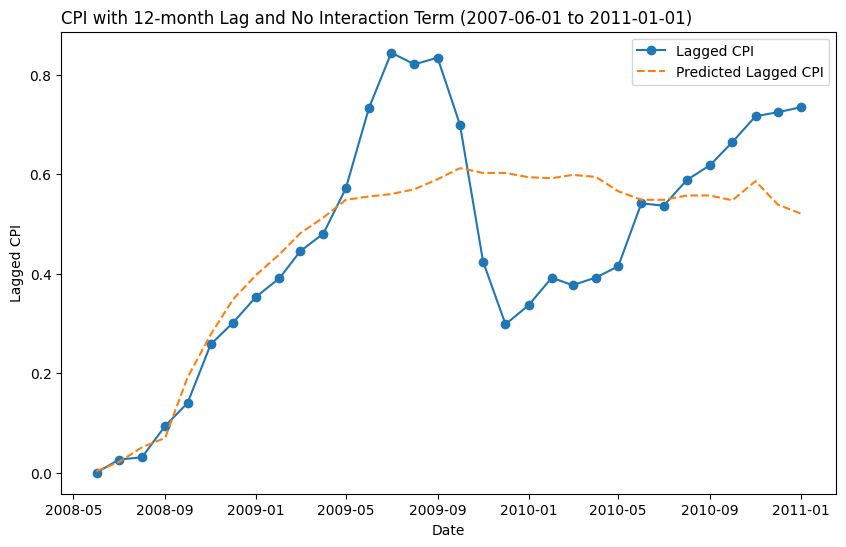

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date='1998-01-01', end_date='2011-01-01'):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Set your FRED API key here
api_key = '7913092cb97545d7c236897b524805da'  # Replace with your actual FRED API key

# Retrieve data from FRED API for the Financial Crisis period (2007-06-01 to 2011-01-01)
start_date = '2007-06-01'
end_date = '2011-01-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Apply a fixed 12-month lag to the CPI data
def apply_12_month_lag(data):
    data['Lagged_CPI'] = data['CPI'].shift(12)
    data.dropna(inplace=True)
    return data

# Apply the 12-month lag to the CPI data
lagged_data = apply_12_month_lag(merged_df)

# Perform the multiple regression with the lagged CPI data and no interaction term
X = lagged_data[['Unemployment Rate', 'FEDFUNDS']]
y = lagged_data['Lagged_CPI']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Print the R-squared value of the model
r2 = r2_score(y, y_pred)
print(f'R-squared of the model with no interaction term and 12-month lag: {r2}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lagged_data['Date'], y, label='Lagged CPI', marker='o')
plt.plot(lagged_data['Date'], y_pred, label='Predicted Lagged CPI', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged CPI')
plt.title(f'CPI with 12-month Lag and No Interaction Term (2007-06-01 to 2011-01-01)', loc='left')
plt.legend()
plt.show()
